In [17]:
import numpy as np
from sklearn.metrics import accuracy_score
import time
from pydl85 import DL85Classifier
import pandas as pd
import numpy as np
import utils
import graphviz
import ast
from tqdm.notebook import tqdm
from multiprocessing import Process, Pool
from functools import partial
import matplotlib.pyplot as plt
FILE_NAME = "lawsuit_k_supp2"

In [18]:
import load_data
X, y, sensitive = load_data.lawsuit()
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [19]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)

    start = time.perf_counter()
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, utils.perf_measure(y_train, y_pred_train, sensitive_train), accuracy_pred, accuracy_test, sum_misclassified_train,
            discrimination_train,       sum_discrimination_additive_train,      sum_discrimination_additive_train_abs,
            discrimination_train_pred,  sum_discrimination_additive_train_pred, sum_discrimination_additive_train_pred_abs,
            discrimination_test,        sum_discrimination_additive_test_pred,  sum_discrimination_additive_test_pred_abs,
            duration, min_supp, clf.tree_]

pool = Pool()
if False:
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 4, 5, 6, 7]:
        for k in [0, 5, 10, 50, 100, 150, 200, 250, 500, 1000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(1, 101, 2)):
        result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        
        
        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), tqdm(args)):
            result.loc[len(result.index)] = res


        #result = result.sort_values(['k', 'depth', 'min_supp'])
        result.to_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv', index=False)

In [20]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"]) 
for random_state in tqdm(range(1, 101, 2)):
  result = pd.concat([result, pd.read_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv')])
  result.to_csv('save/'+FILE_NAME+'.csv', index=False)
result

  0%|          | 0/50 [00:00<?, ?it/s]

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,sum_discrimination_additive_train_abs,discrimination_train_pred,sum_discrimination_additive_train_pred,sum_discrimination_additive_train_pred_abs,discrimination_test,sum_discrimination_additive_test_pred,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,1,51.0,0.755981,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.043235,2,"{'feat': 10, 'left': {'value': 1, 'error': 0, ..."
1,5,1,1,51.782379,0.752237,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.007271,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.7..."
2,10,1,1,52.564762,0.748494,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.017863,2,"{'feat': 10, 'left': {'value': 1, 'error': 1.5..."
3,50,1,1,58.823811,0.718546,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.038281,2,"{'feat': 10, 'left': {'value': 1, 'error': 7.8..."
4,100,1,1,66.647621,0.681112,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.005959,2,"{'feat': 10, 'left': {'value': 1, 'error': 15...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,200,7,99,60.074806,0.712561,"((53, 4, 12, 53), (14, 14, 1, 58))",0.851675,0.826923,31,0.360373,...,0.360373,0.145374,0.145374,0.145374,0.00319,0.00319,0.299841,3.15337,2,"{'feat': 6, 'left': {'value': 0, 'error': 0, '..."
73,250,7,99,67.343513,0.677782,"((53, 4, 12, 53), (14, 14, 1, 58))",0.851675,0.826923,31,0.360373,...,0.360373,0.145374,0.145374,0.145374,0.00319,0.00319,0.299841,2.547931,2,"{'feat': 6, 'left': {'value': 0, 'error': 0, '..."
74,500,7,99,98.638214,0.528047,"((43, 5, 22, 52), (14, 11, 1, 61))",0.813397,0.769231,39,0.360373,...,0.389957,0.106086,0.106086,0.119276,0.055821,0.055821,0.38437,1.647809,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat..."
75,1000,7,99,150.54248,0.279701,"((43, 8, 22, 49), (14, 16, 1, 56))",0.77512,0.769231,47,0.360373,...,0.389957,0.073205,0.073205,0.103542,-0.027113,-0.027113,0.467305,3.044549,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat..."


accuracy_pred = 0.89952153
accuracy_test = 0.86538462
discrimination_train = 0.32561905
discrimination_train_pred = 0.238


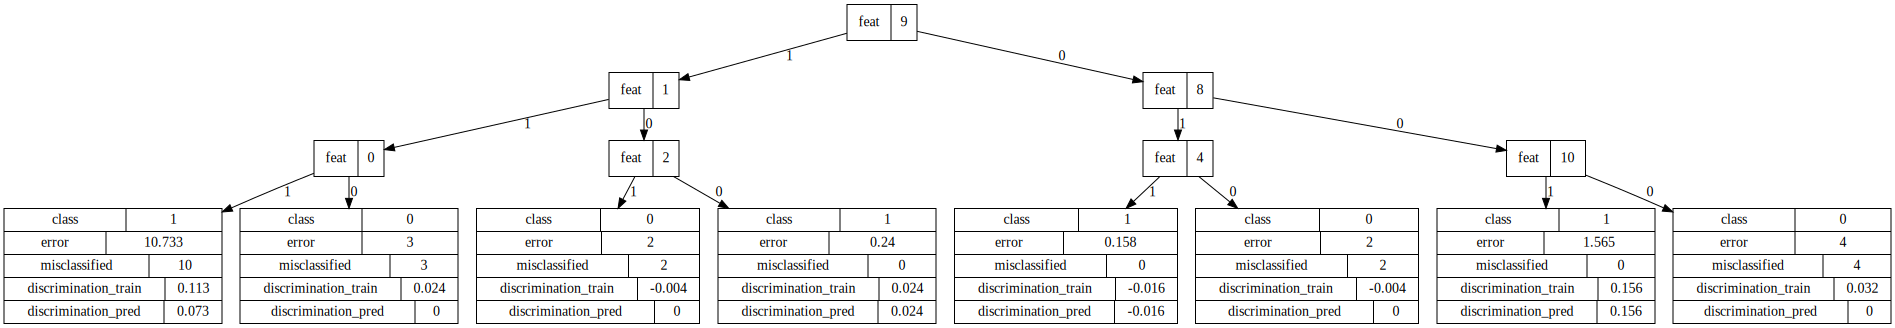

In [21]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


In [22]:
discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
print(sum_discrimination_additive_test_pred)
sum_discrimination_additive_test_pred_abs

0.26060606060606056


0.5393939393939394

In [23]:
discri_test

[-0.09393939393939393,
 -0.045454545454545456,
 0.0,
 0.06666666666666667,
 0.0,
 0.0,
 0.26666666666666666,
 0.06666666666666667]

In [24]:
utils.discrimination(y_train, sensitive_train)

0.32561904761904764

In [25]:
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train', do_abs=True))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred', do_abs=True))

0.3256190476190476
0.3728571428571429
0.23800000000000002
0.26961904761904765


In [26]:
utils.sum_elem_tree(clf.tree_, 'misclassified')

21

In [27]:
print(utils.discrimination(y_train, sensitive_train))
print(utils.discrimination(y_pred_train, sensitive_train))
print(utils.discrimination(y_test, sensitive_test))
print(utils.discrimination(y_pred_test, sensitive_test))

0.32561904761904764
0.238
0.2606060606060606
0.29393939393939394


In [28]:
clf.tree_

{'feat': 9,
 'left': {'feat': 1,
  'left': {'feat': 0,
   'left': {'value': 1,
    'error': 10.733334,
    'transactions': [128,
     129,
     130,
     131,
     132,
     133,
     135,
     136,
     137,
     139,
     140,
     141,
     143,
     146,
     152,
     153,
     154,
     156,
     157,
     158,
     159,
     160,
     161,
     162,
     165,
     166,
     167,
     168,
     169,
     171,
     174,
     113,
     115,
     117,
     118,
     119,
     120,
     121,
     122,
     123,
     124,
     125,
     126,
     127],
    'proba': [0.23, 0.77],
    'discrimination_additive_train': 0.11276190476190476,
    'discrimination_additive_pred': 0.07333333333333333,
    'misclassified': 10},
   'right': {'value': 0,
    'error': 3,
    'transactions': [134, 173, 175, 144, 145, 114, 176, 116, 148],
    'proba': [0.67, 0.33],
    'discrimination_additive_train': 0.024,
    'discrimination_additive_pred': 0.0,
    'misclassified': 3},
   'transactions': [128,
  

# Graphs

<Figure size 648x432 with 0 Axes>

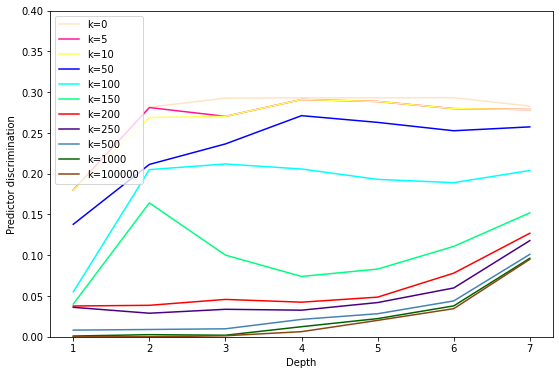

In [29]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4, "Depth", "Predictor discrimination", "Depth_Predictor_discrimination_train")

<Figure size 648x432 with 0 Axes>

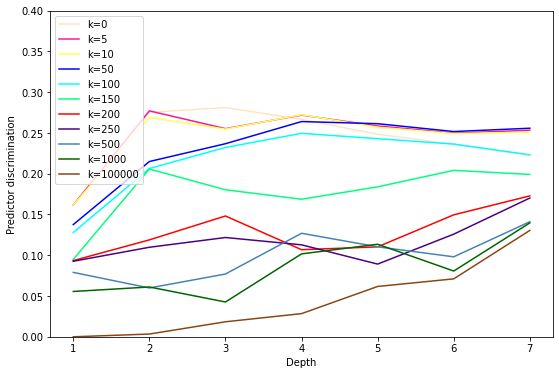

In [30]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4, "Depth", "Predictor discrimination", "Depth_Predictor_discrimination_test")

<Figure size 648x432 with 0 Axes>

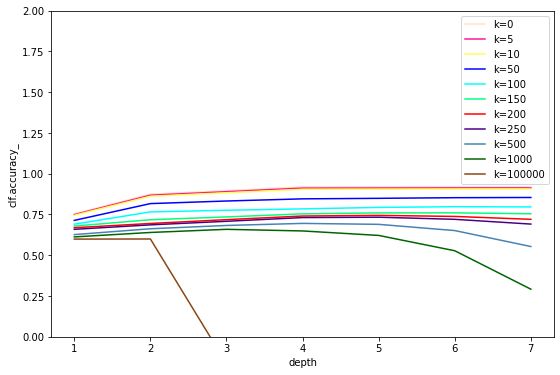

In [31]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

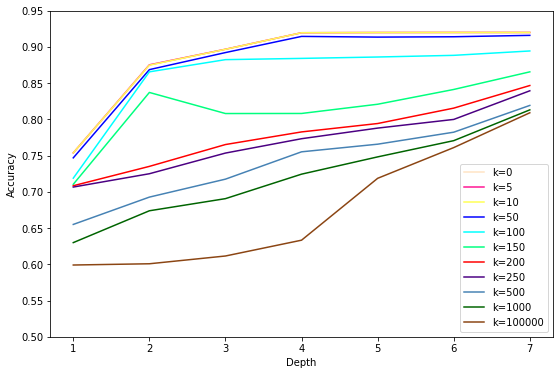

In [32]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95, "Depth", "Accuracy", "Depth_Accuracy_train")

<Figure size 648x432 with 0 Axes>

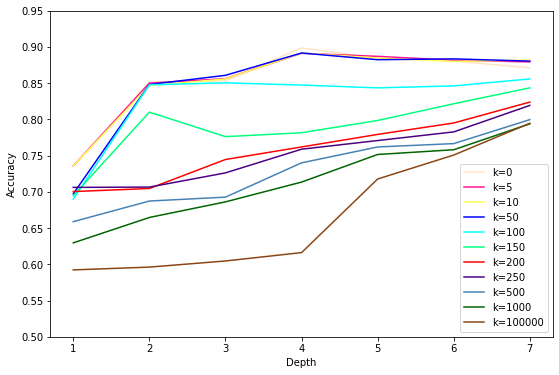

In [33]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95, "Depth", "Accuracy", "Depth_Accuracy_test")

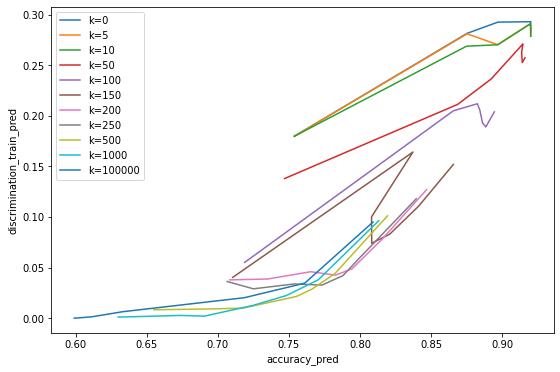

In [18]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

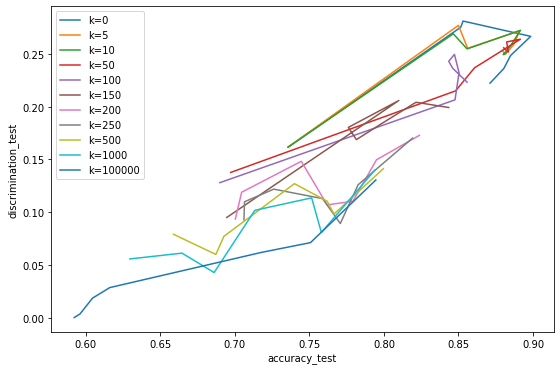

In [19]:
utils.plot2("accuracy_test", "discrimination_test", result)

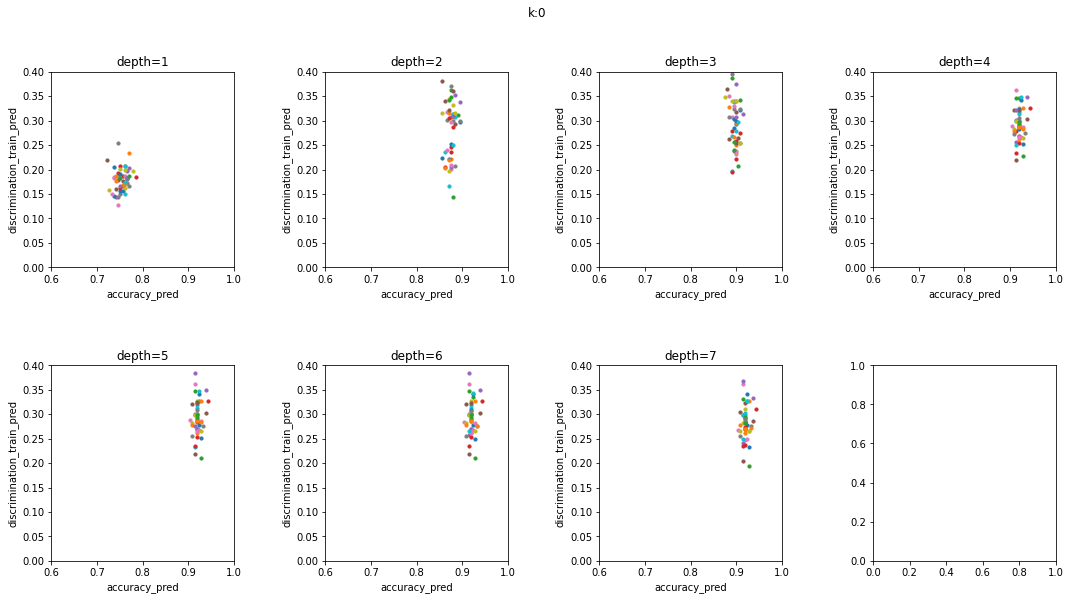

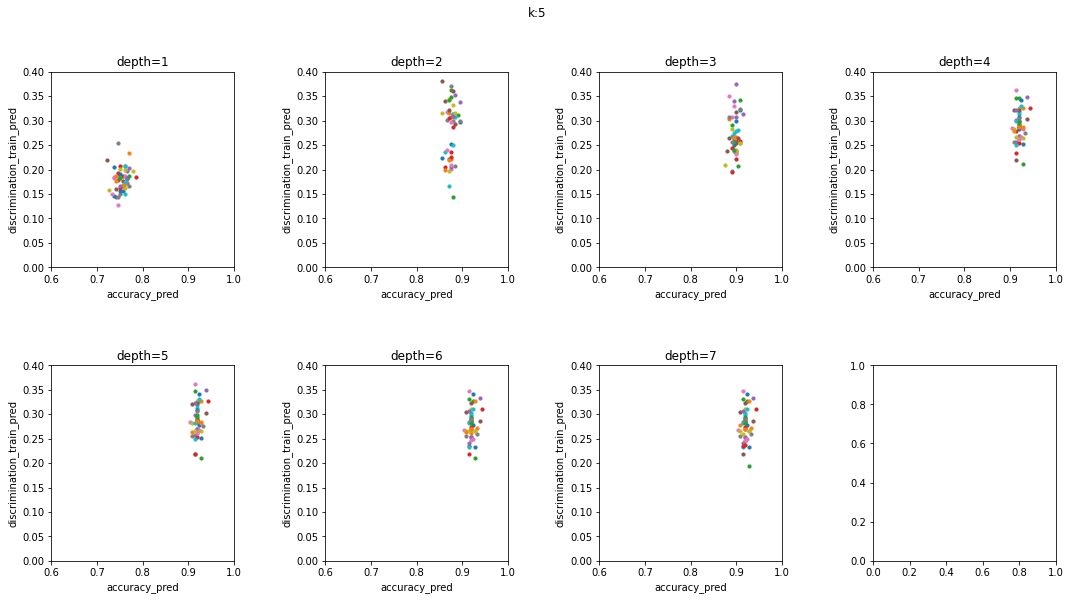

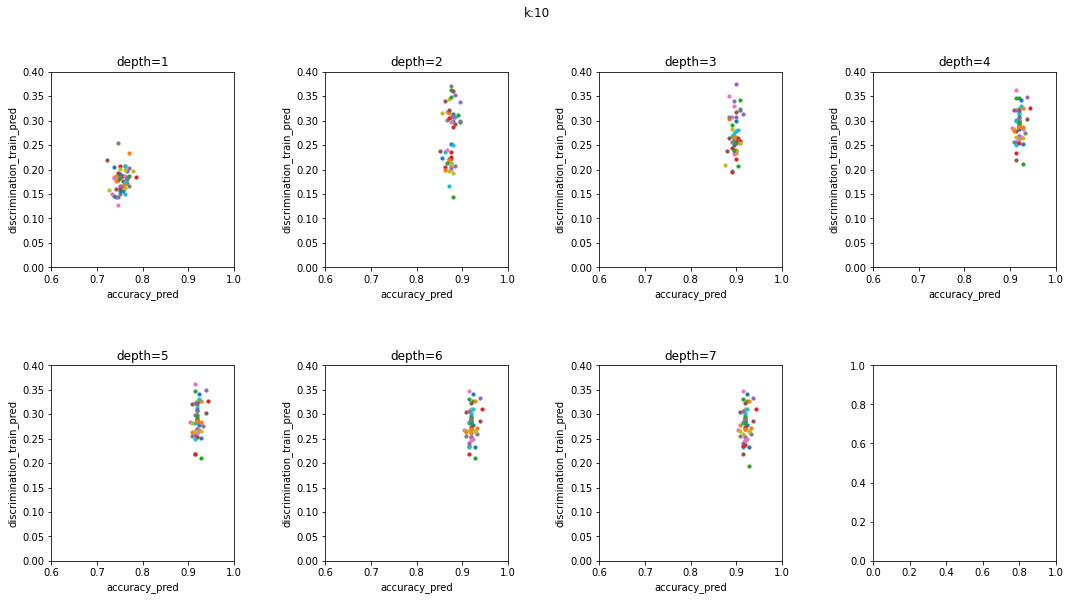

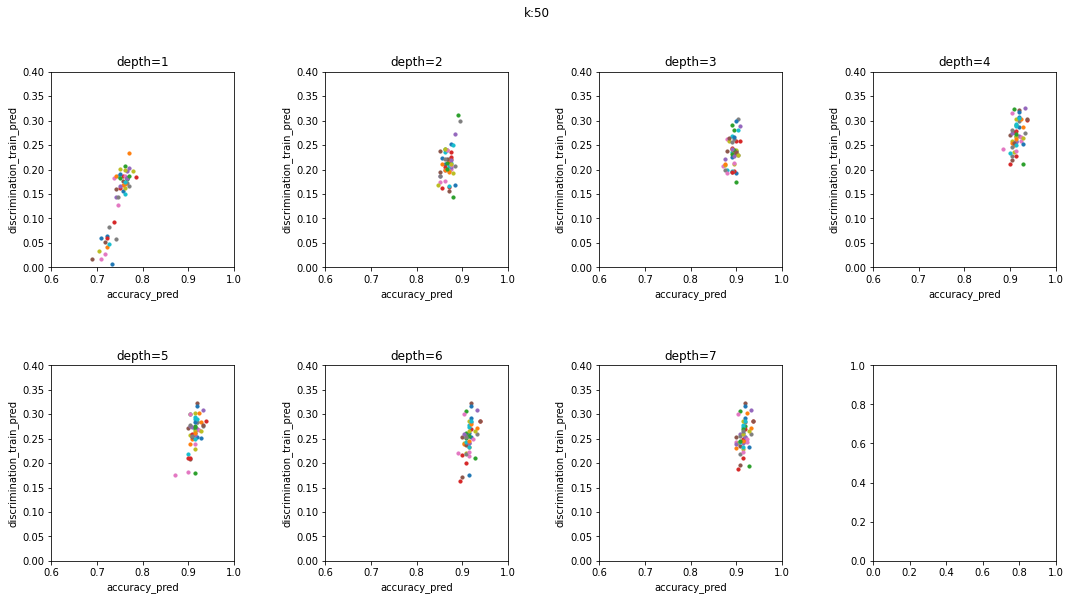

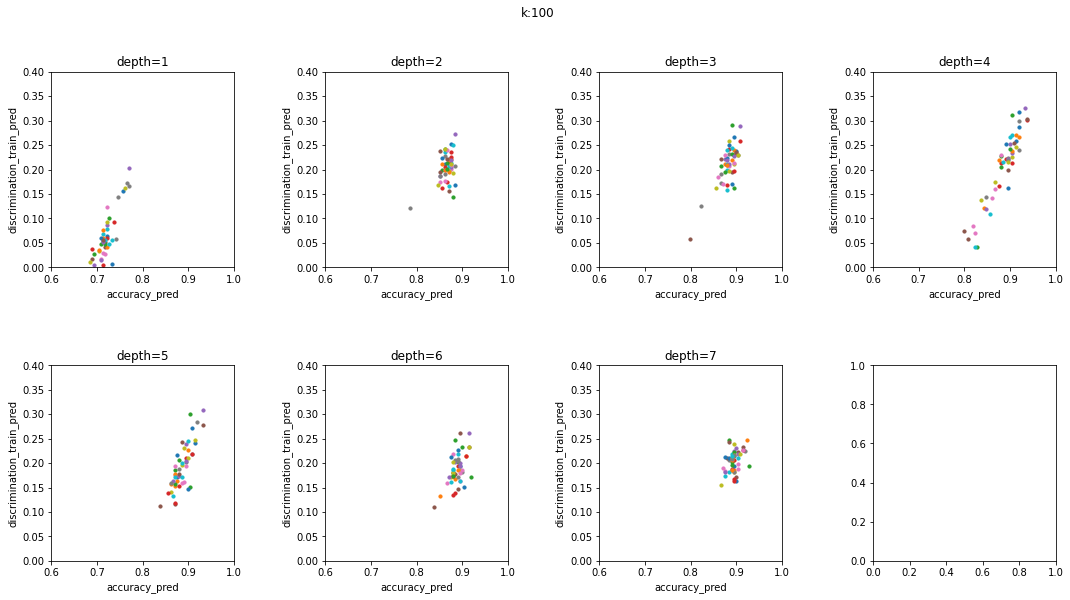

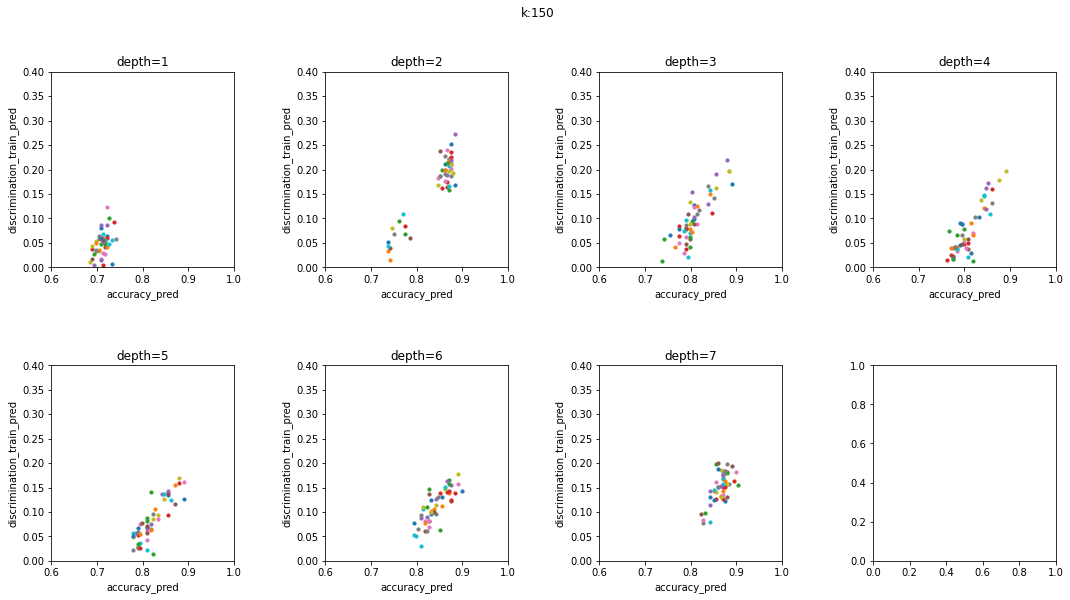

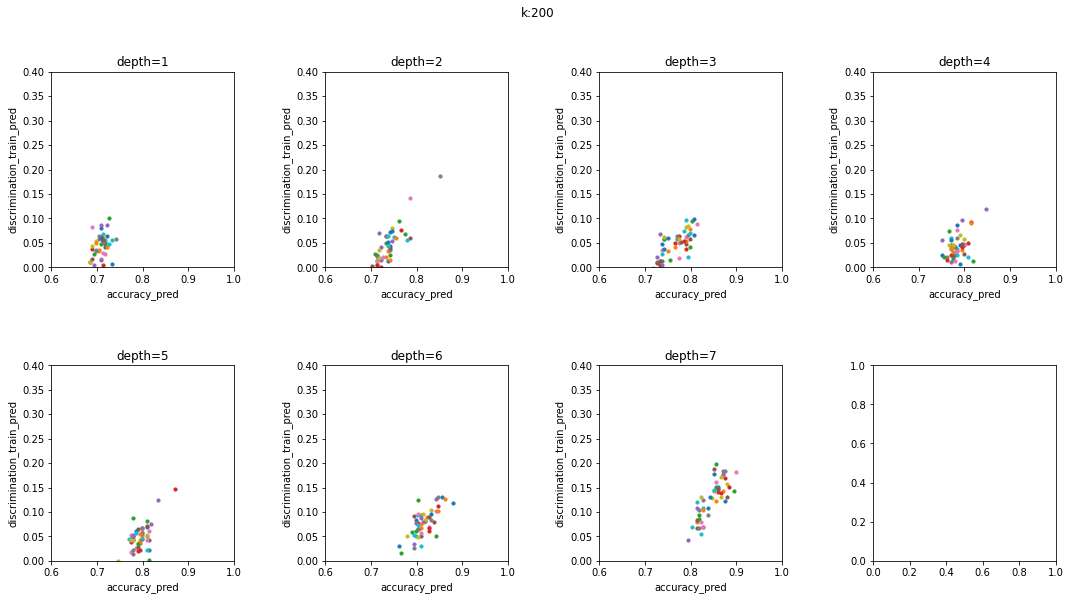

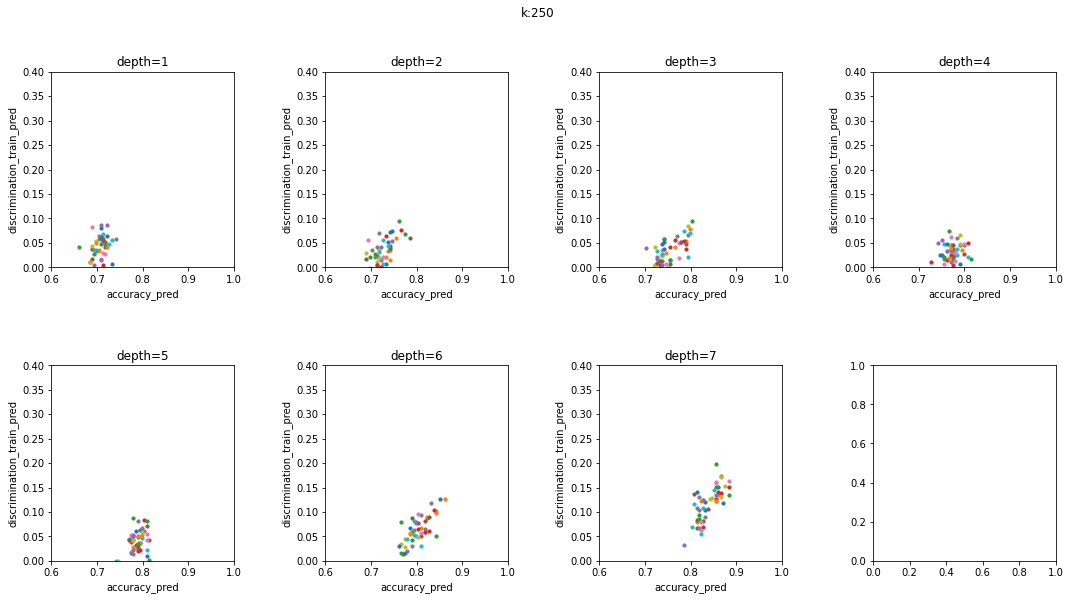

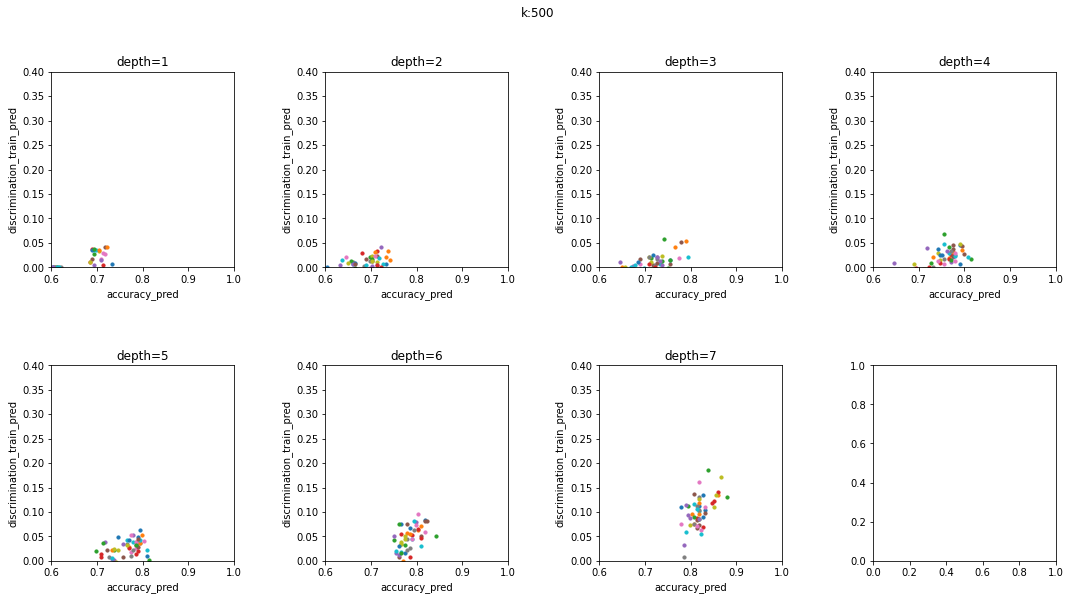

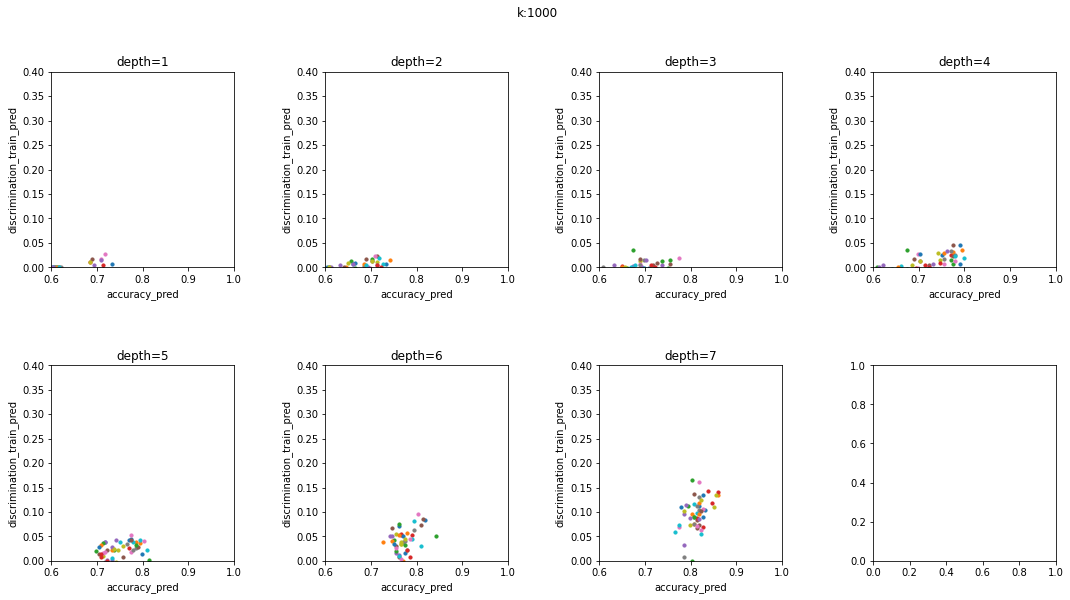

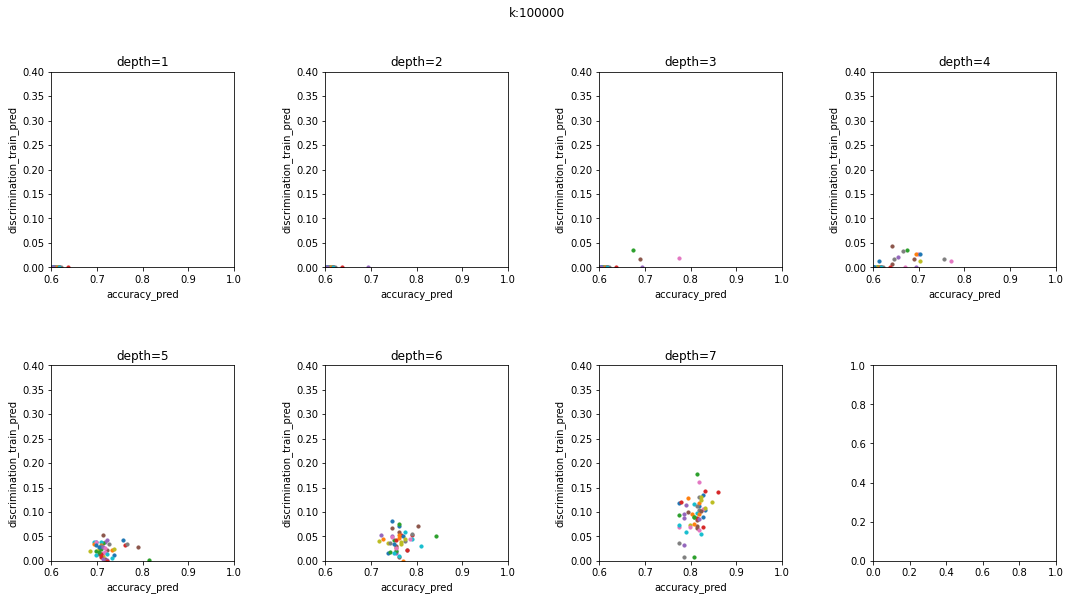

In [20]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

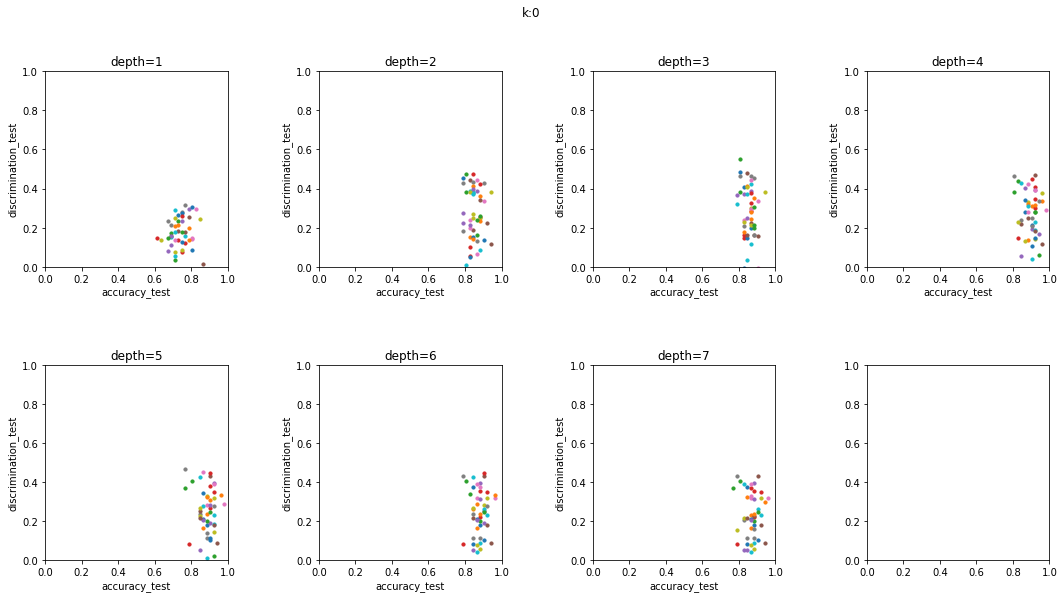

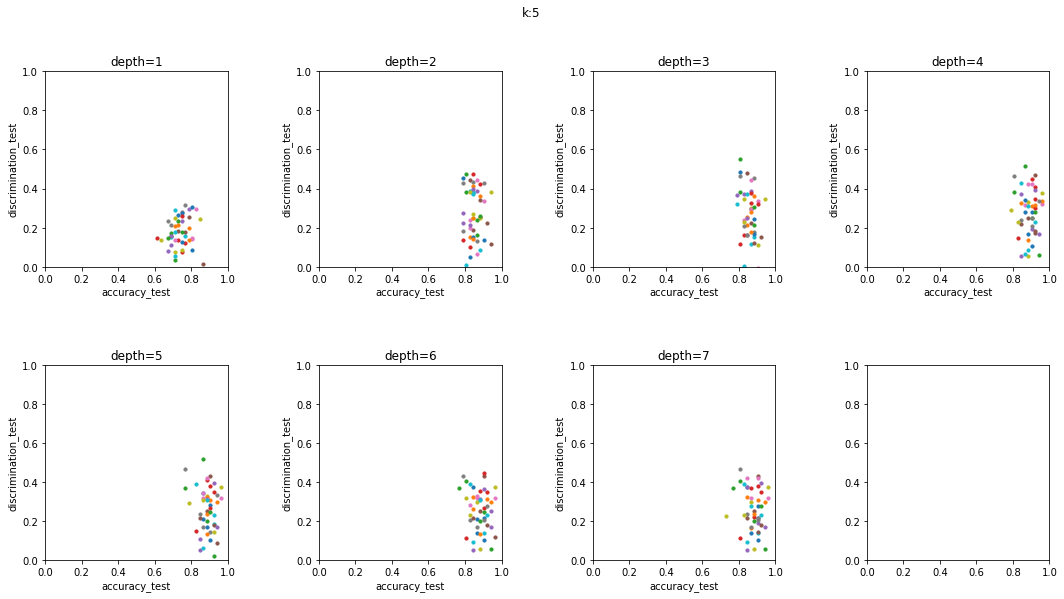

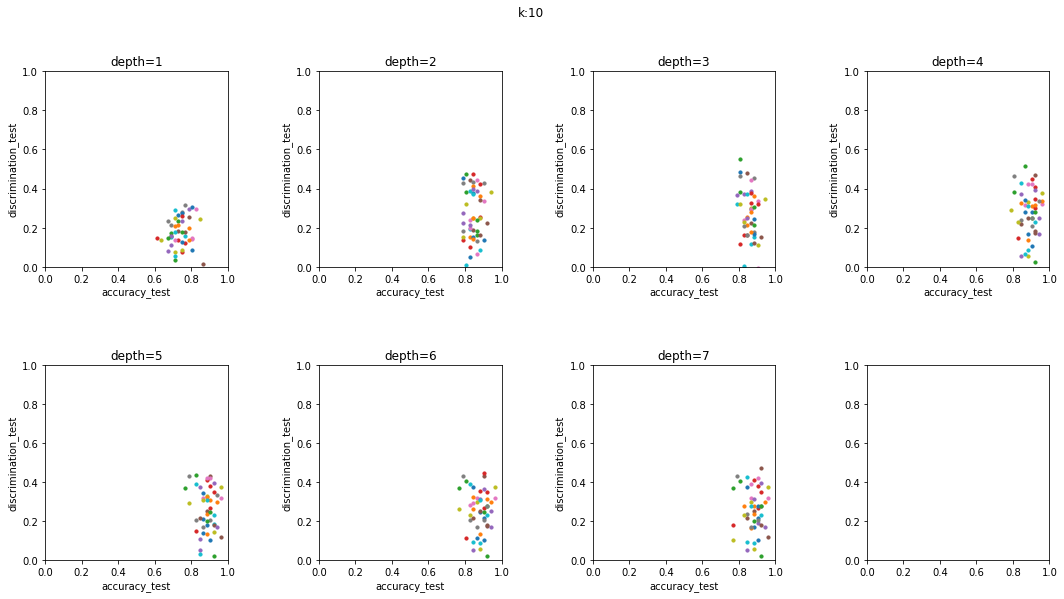

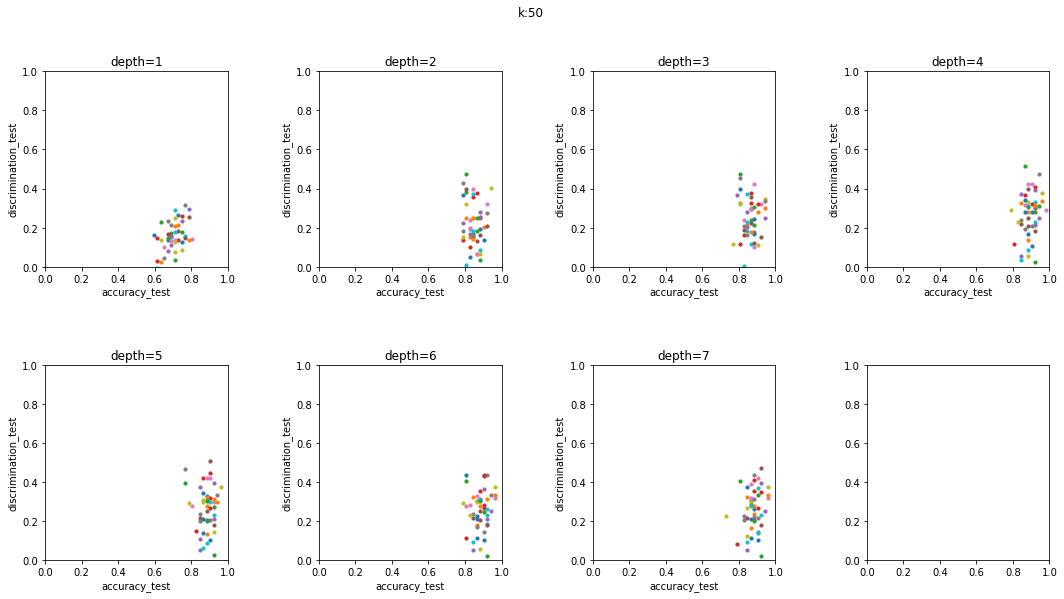

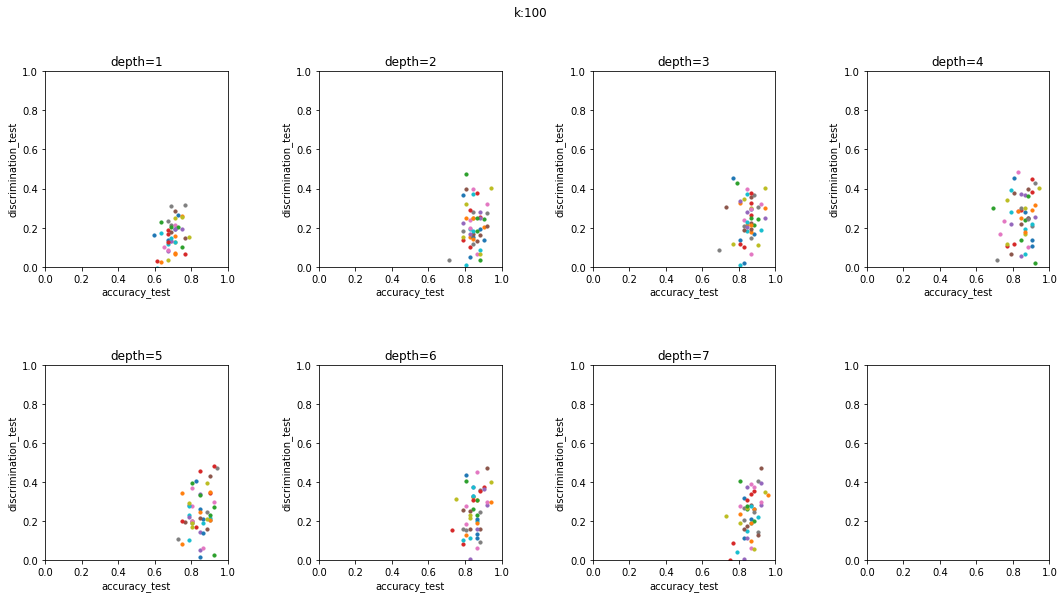

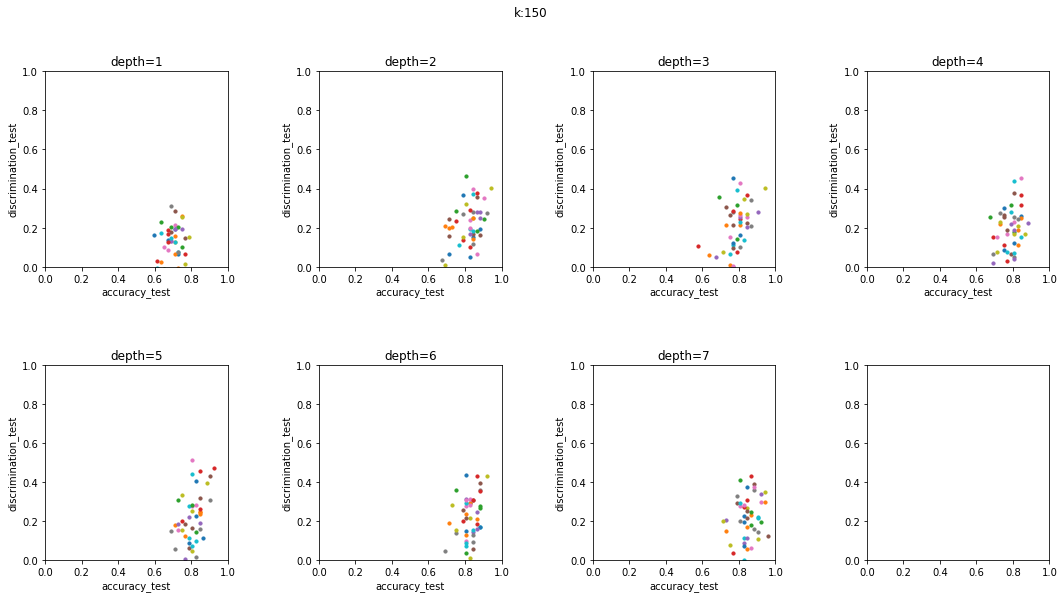

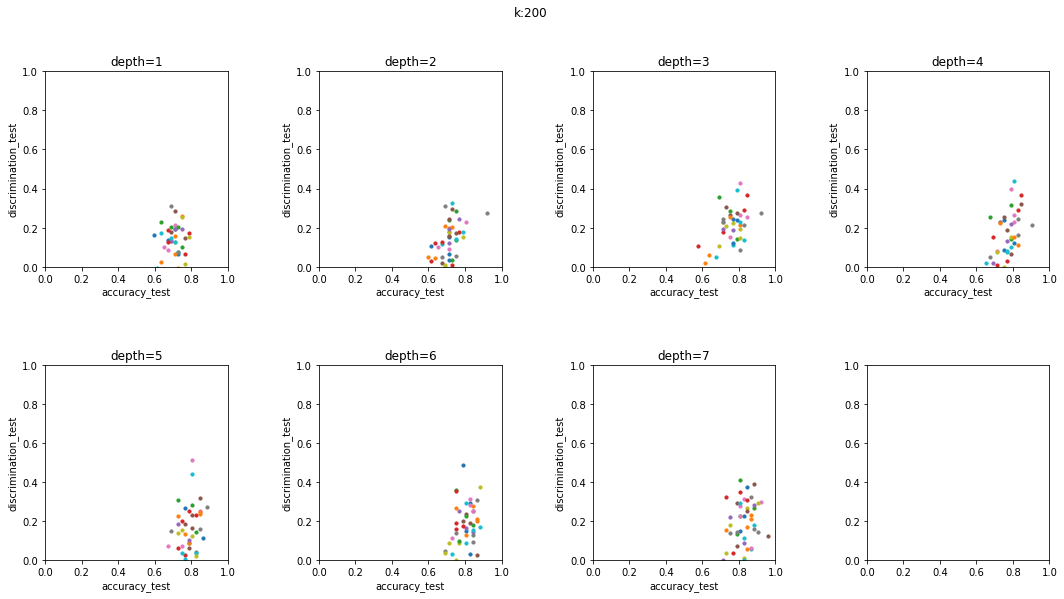

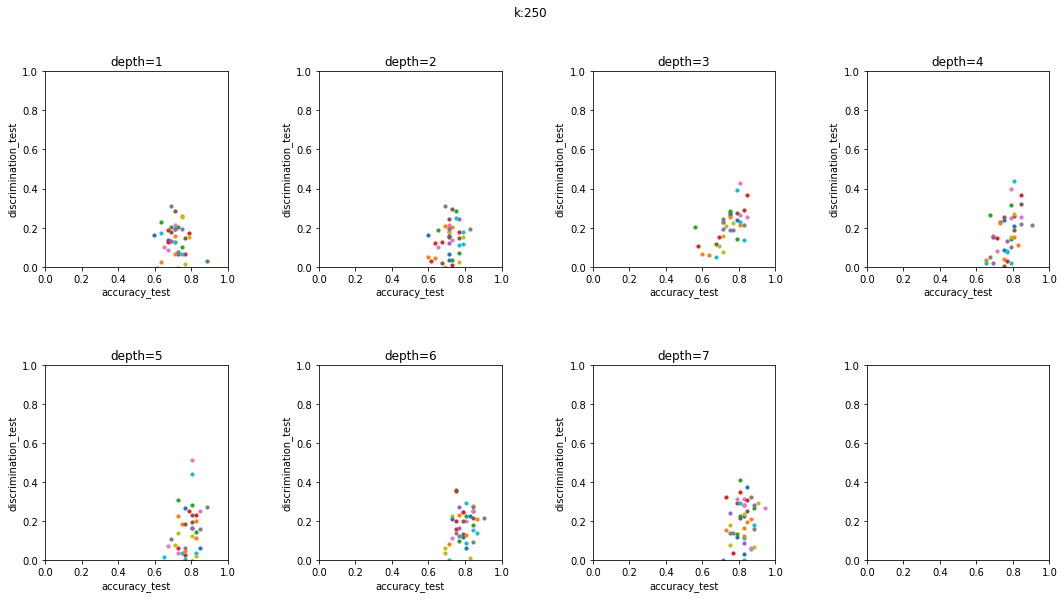

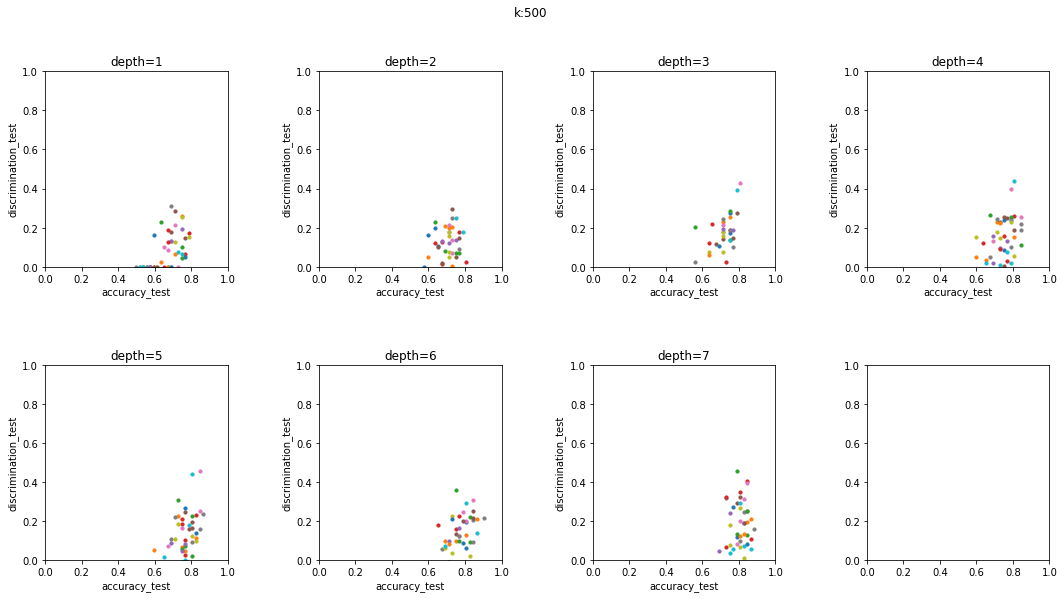

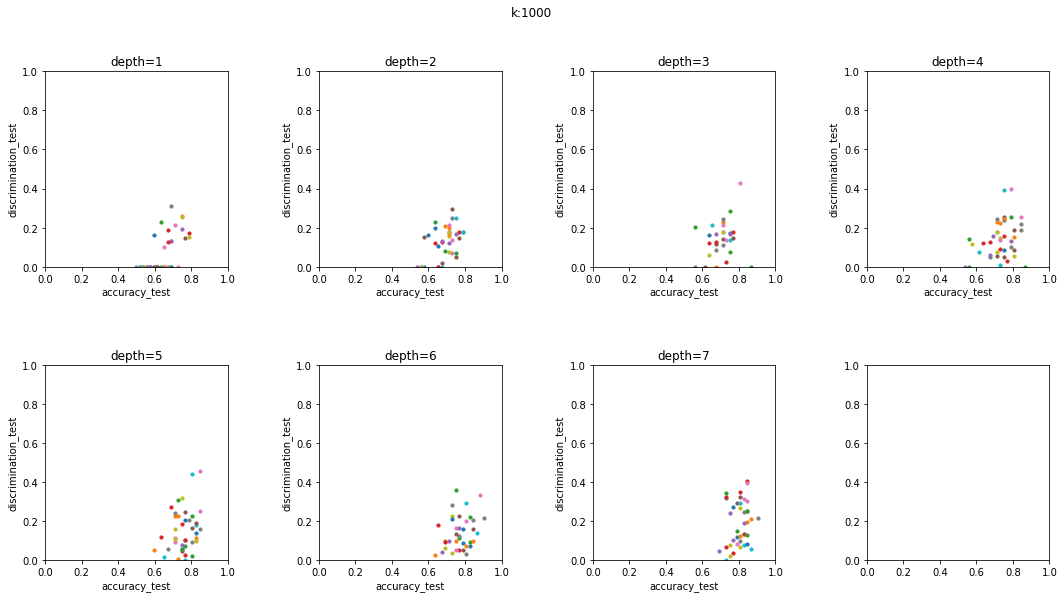

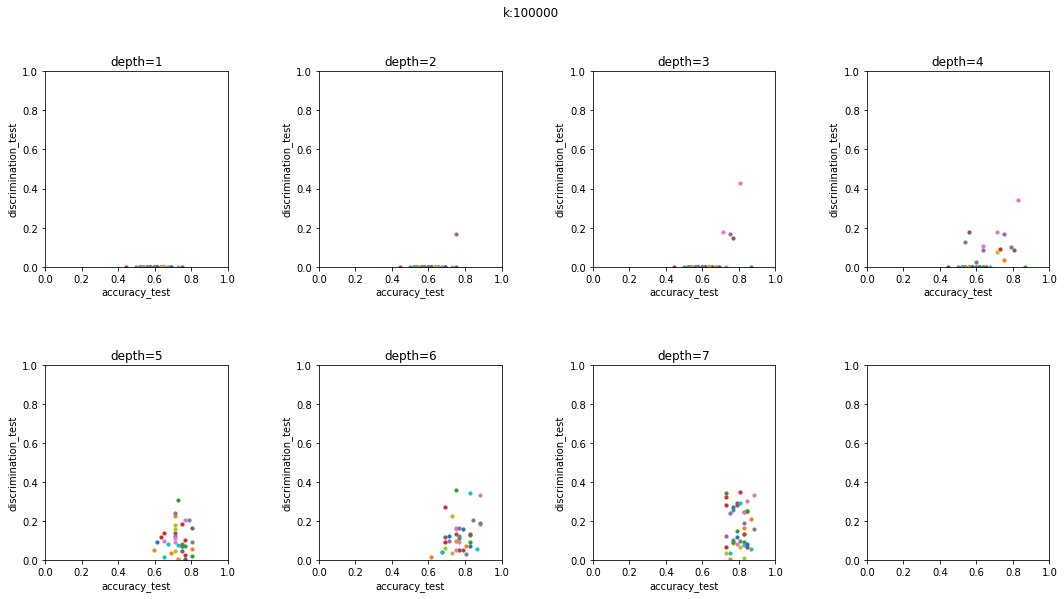

In [21]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

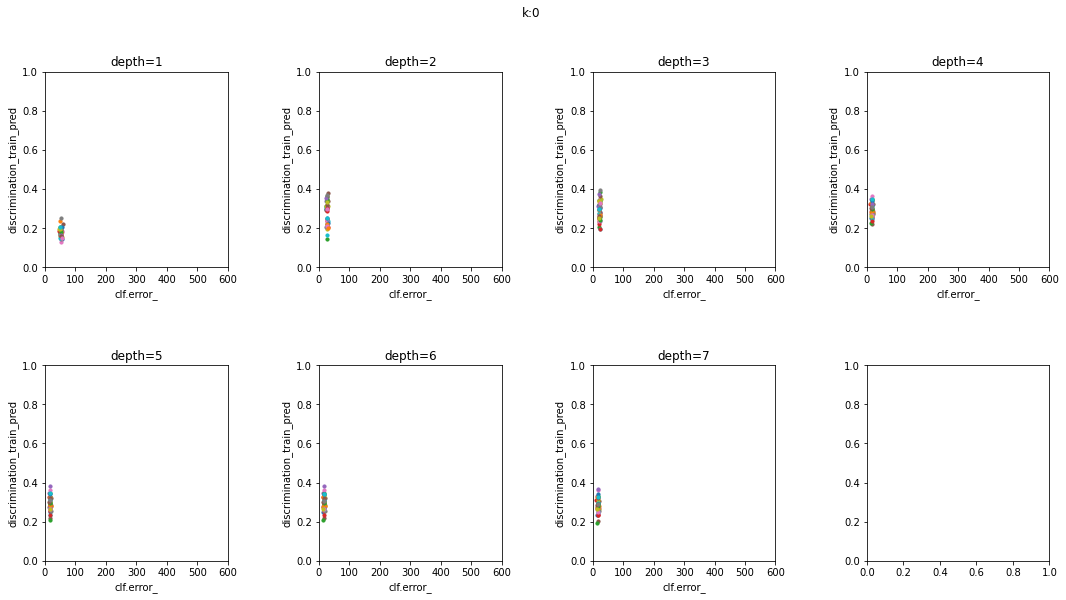

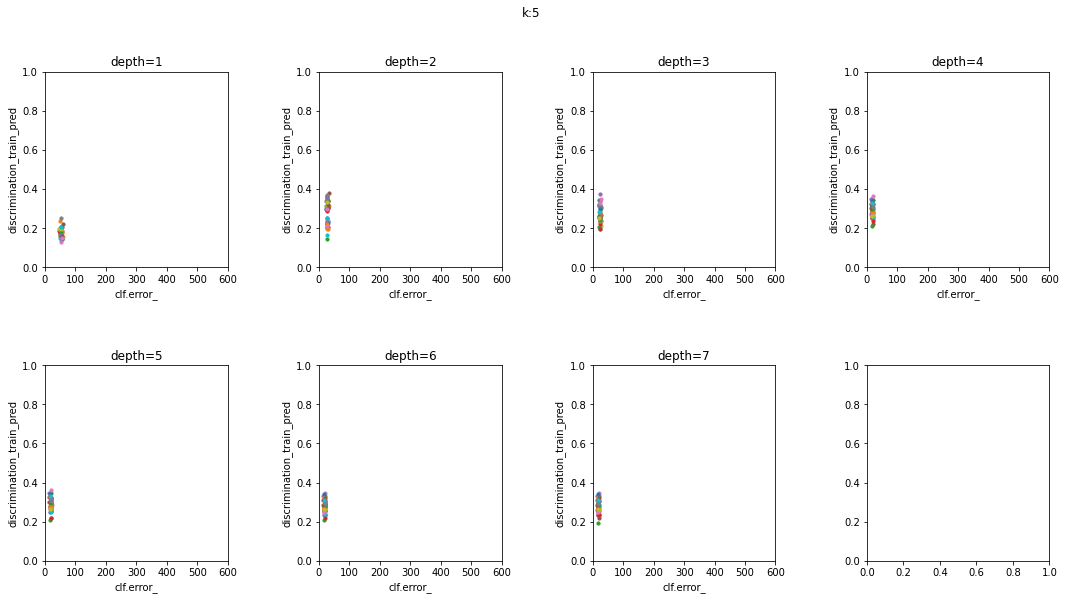

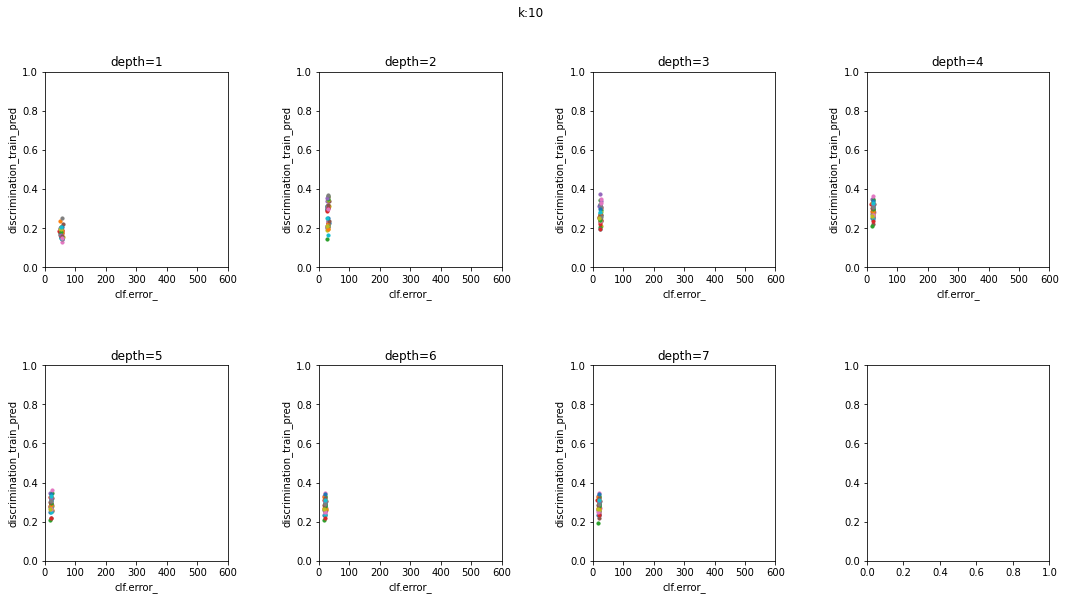

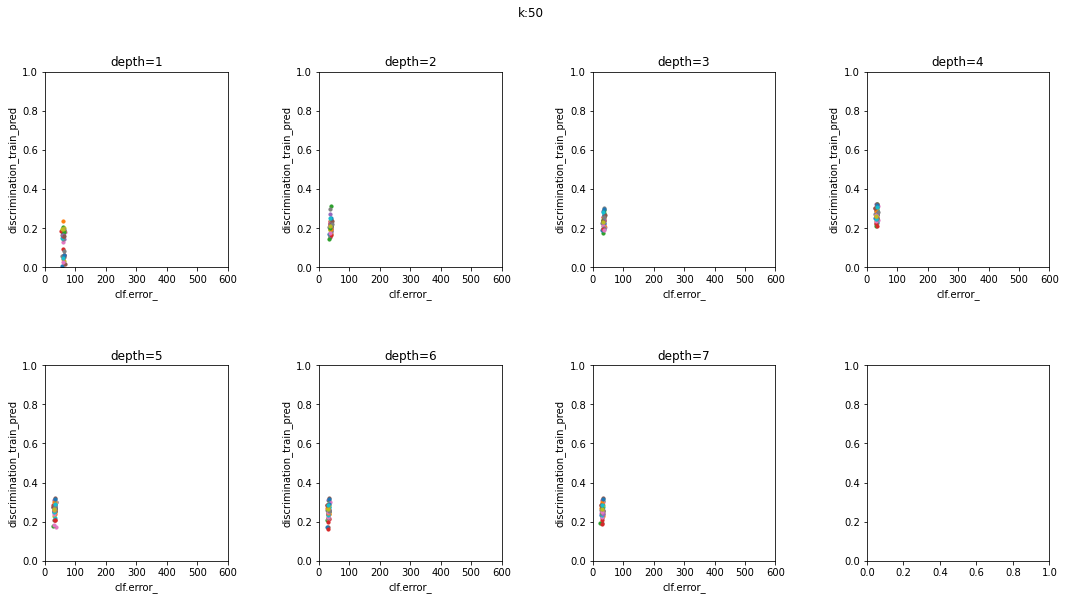

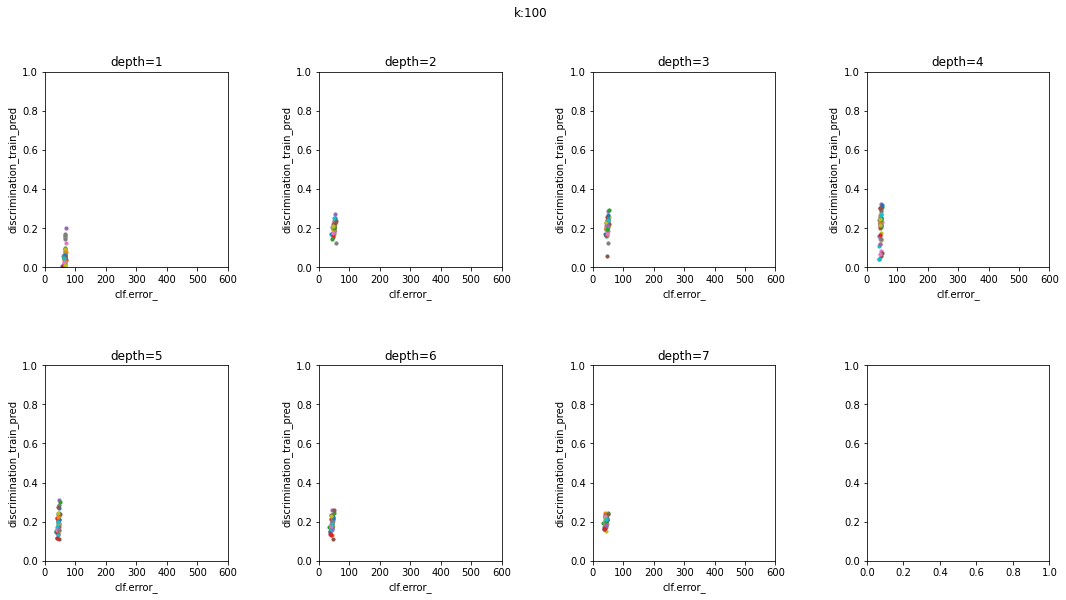

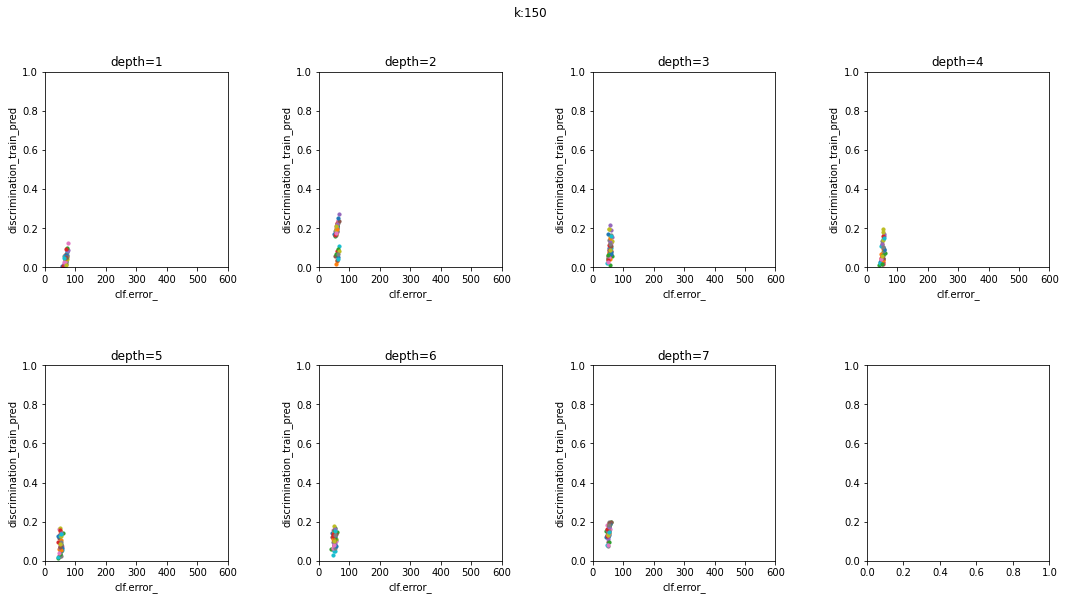

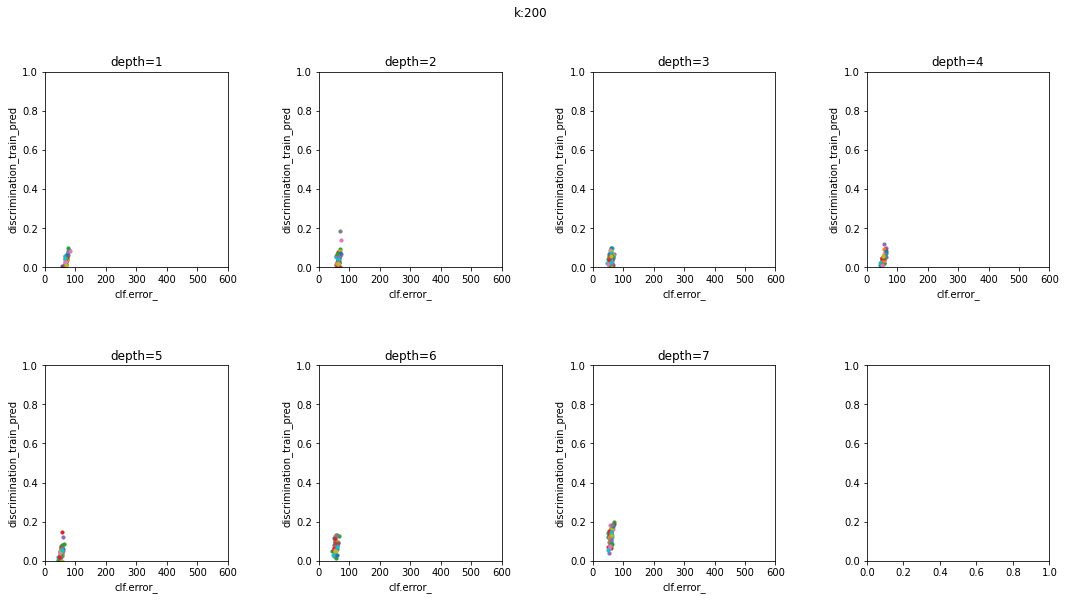

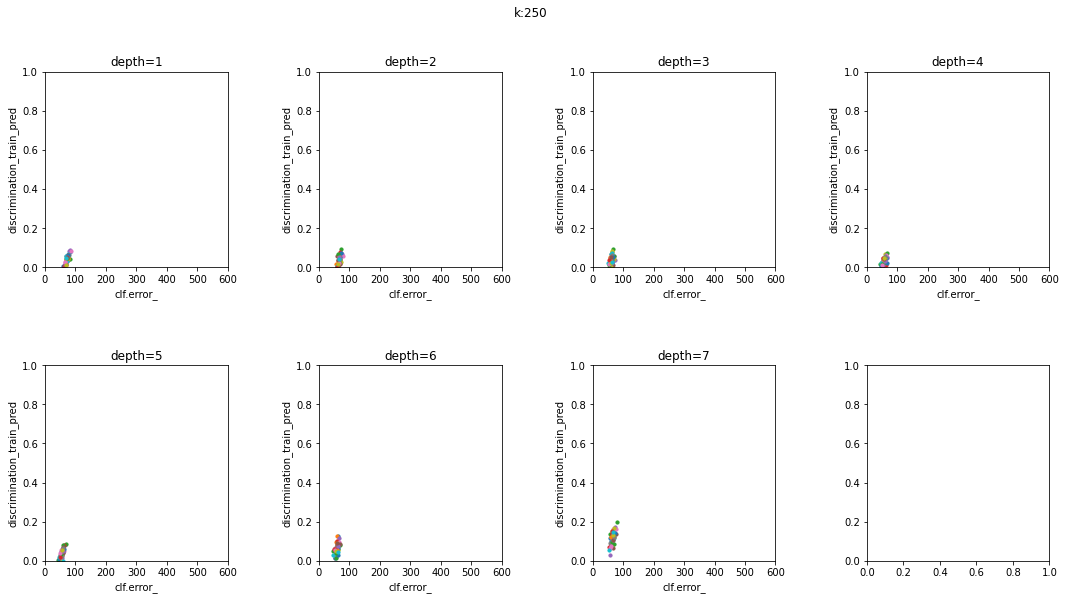

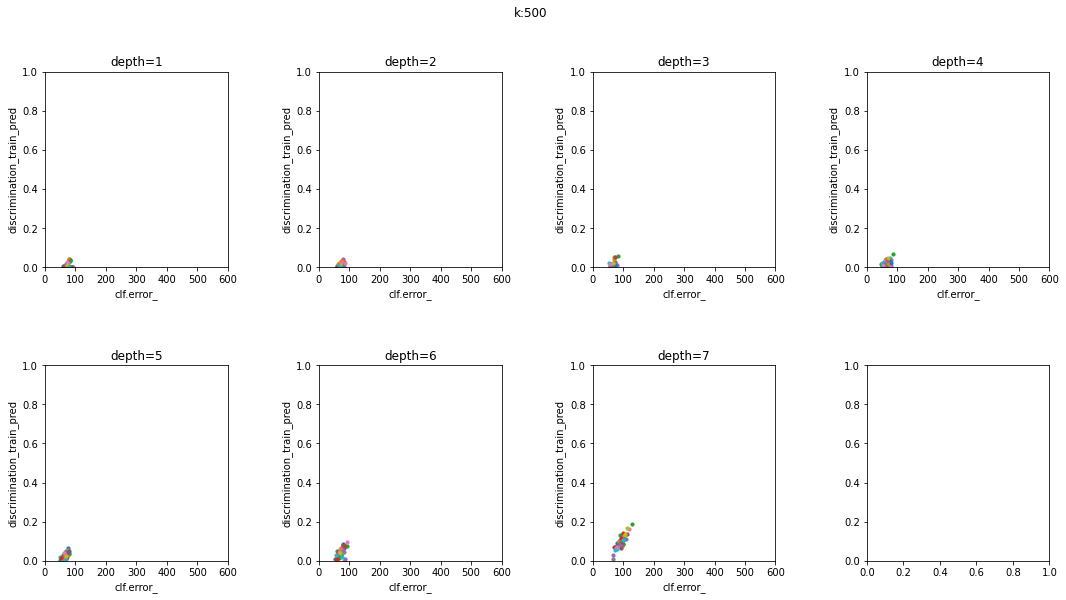

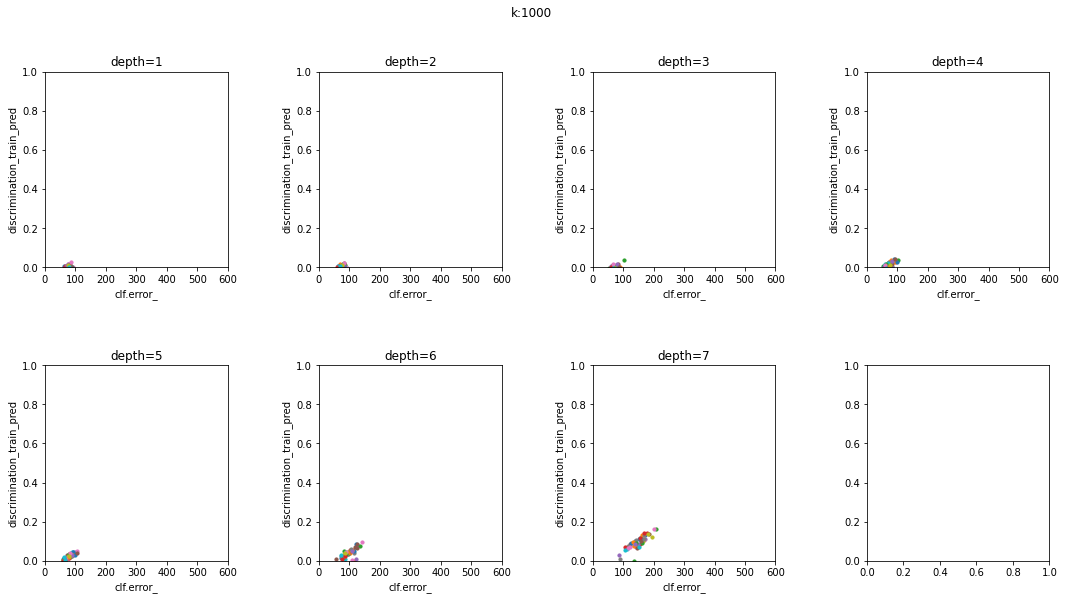

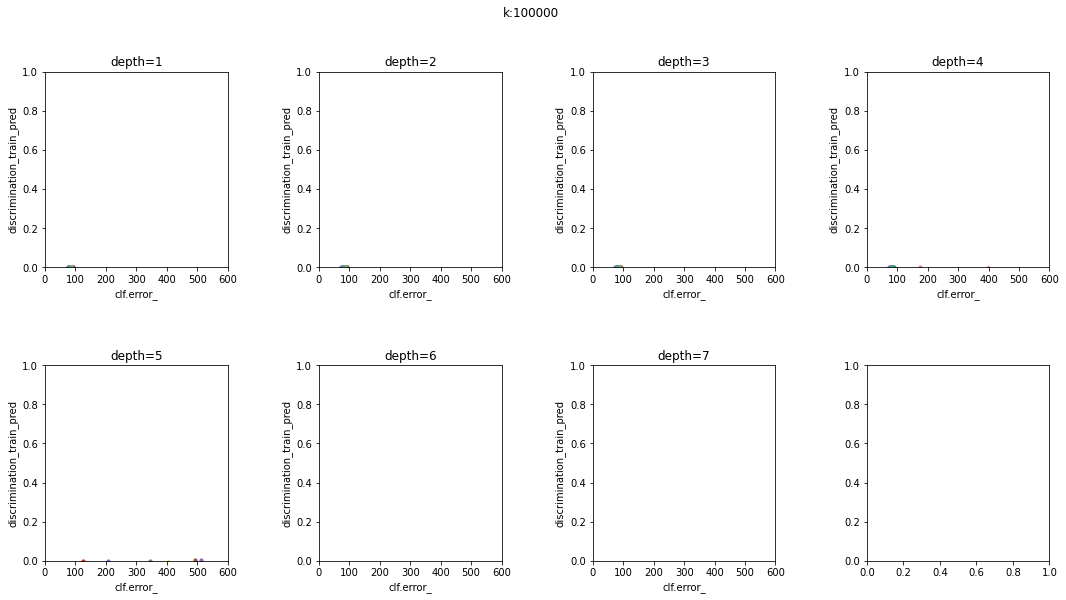

In [22]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

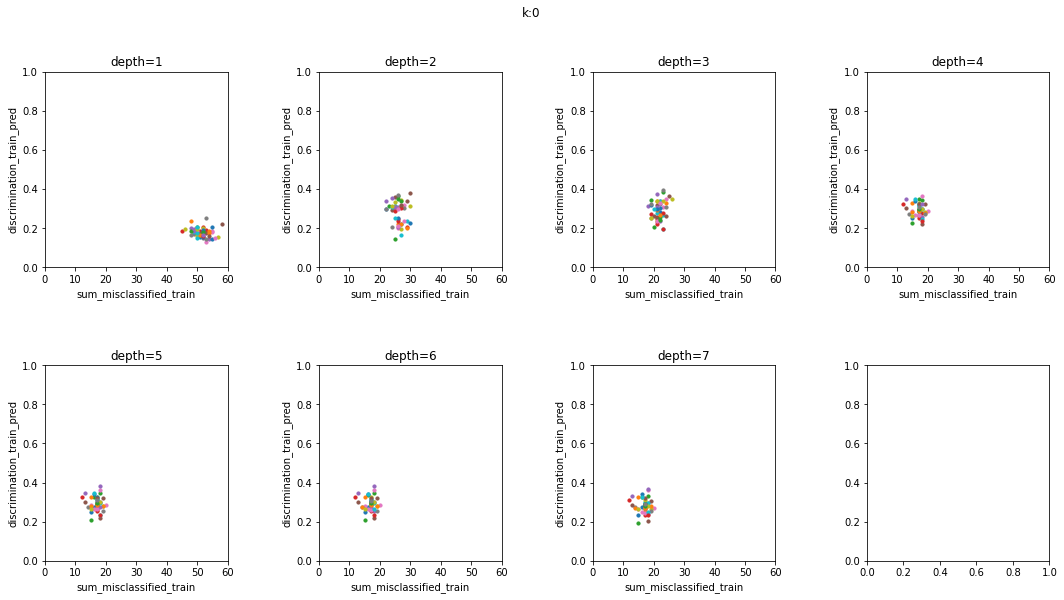

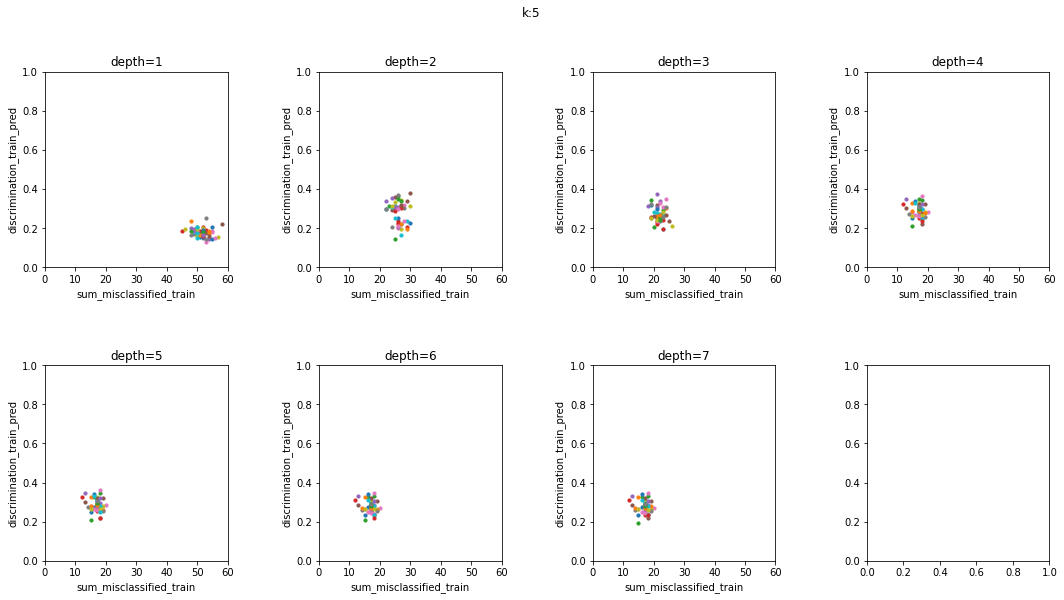

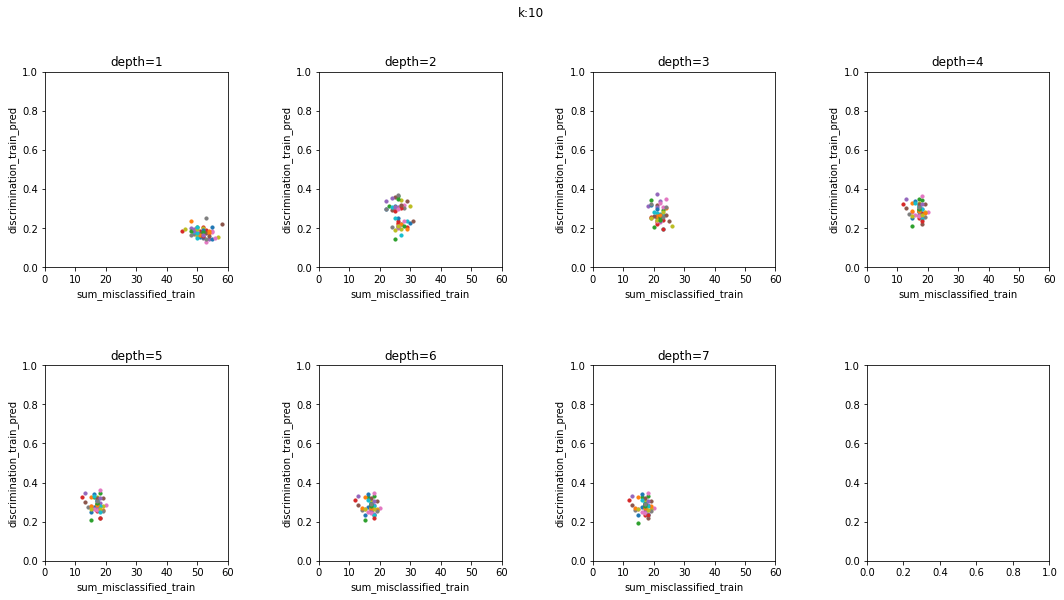

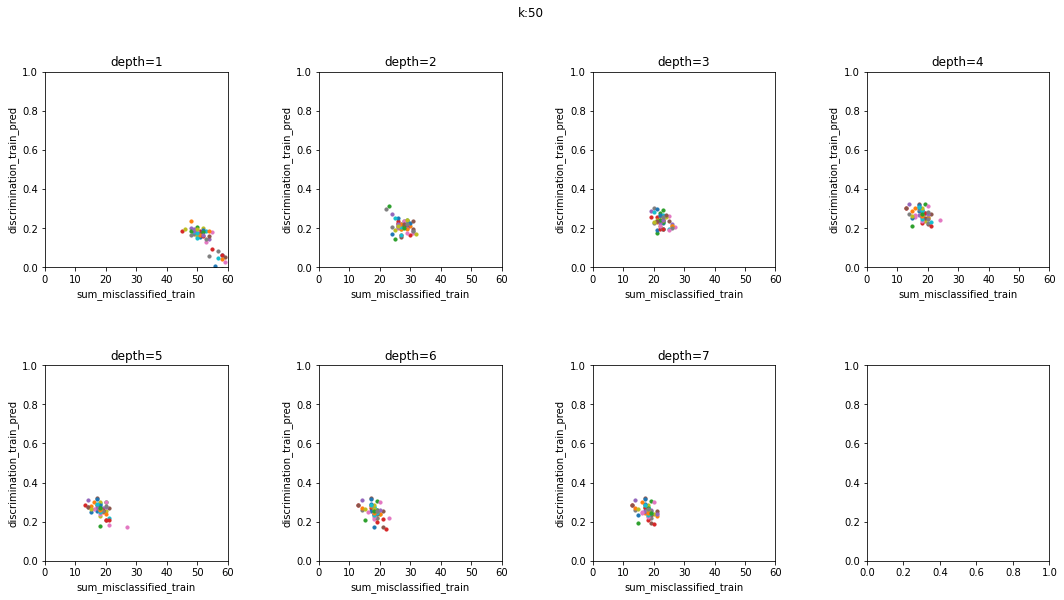

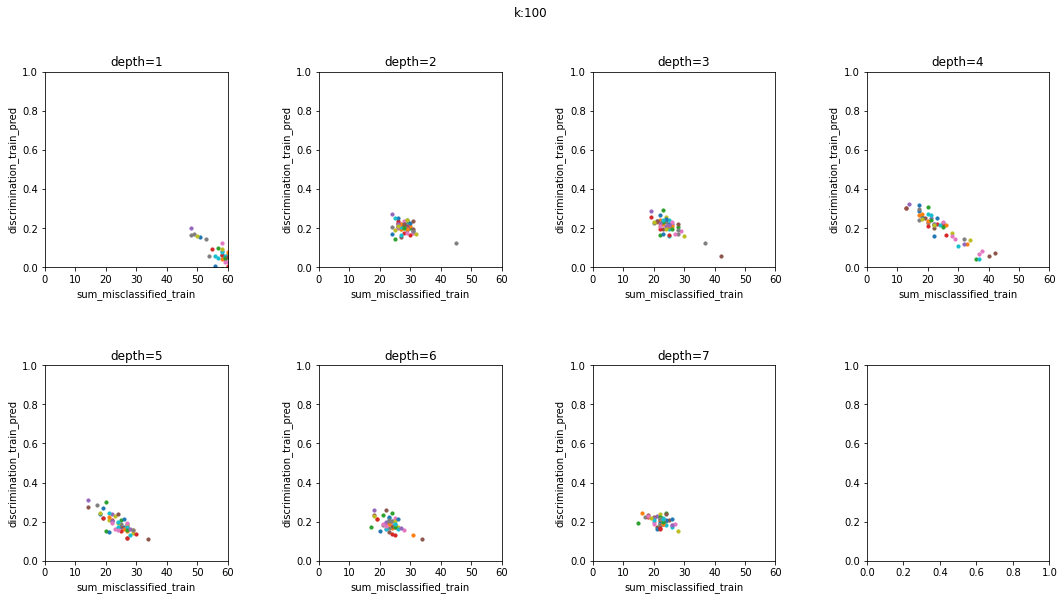

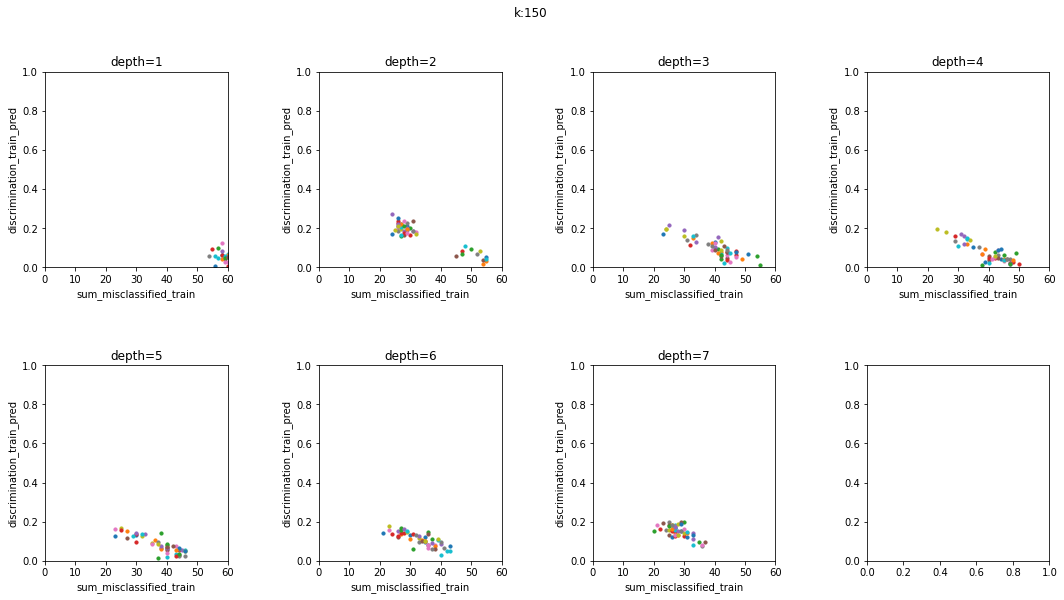

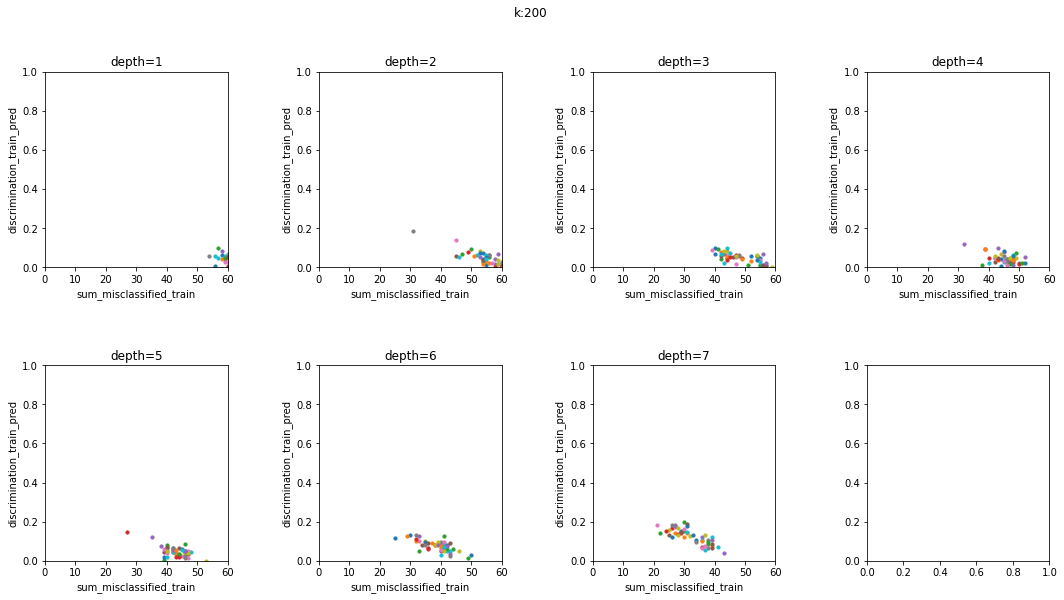

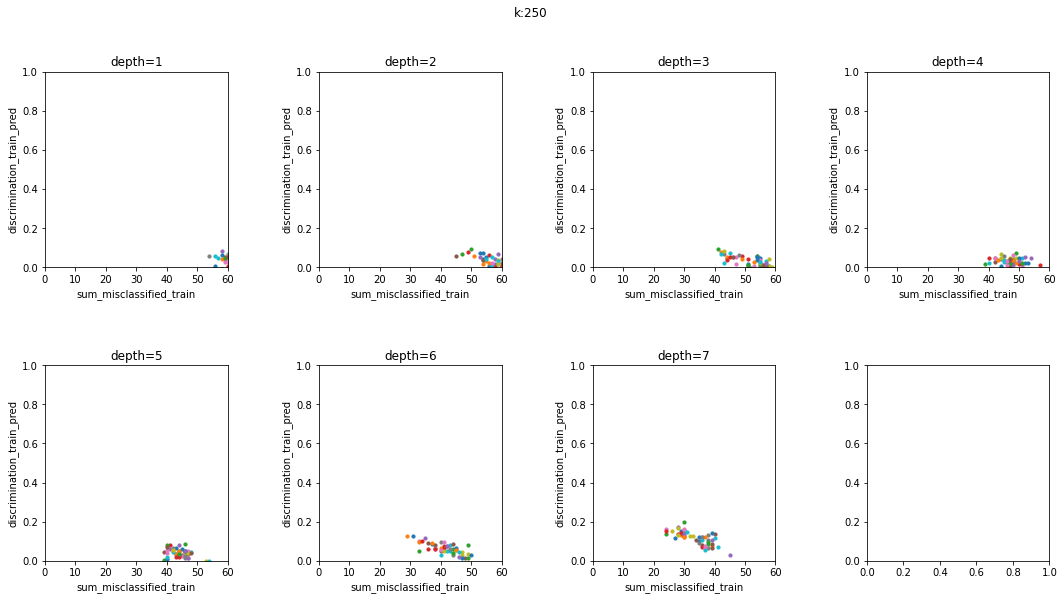

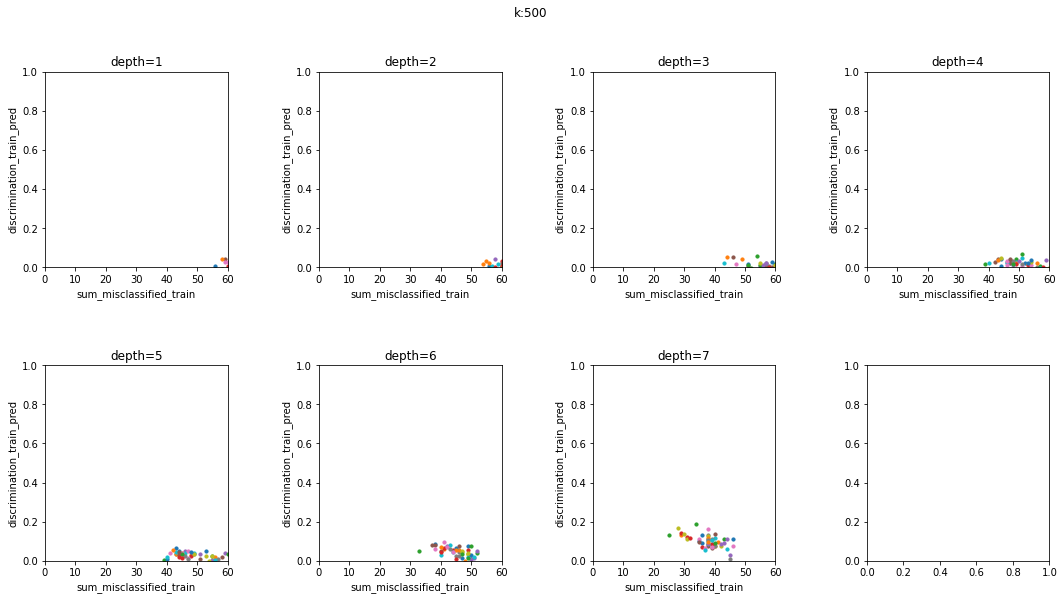

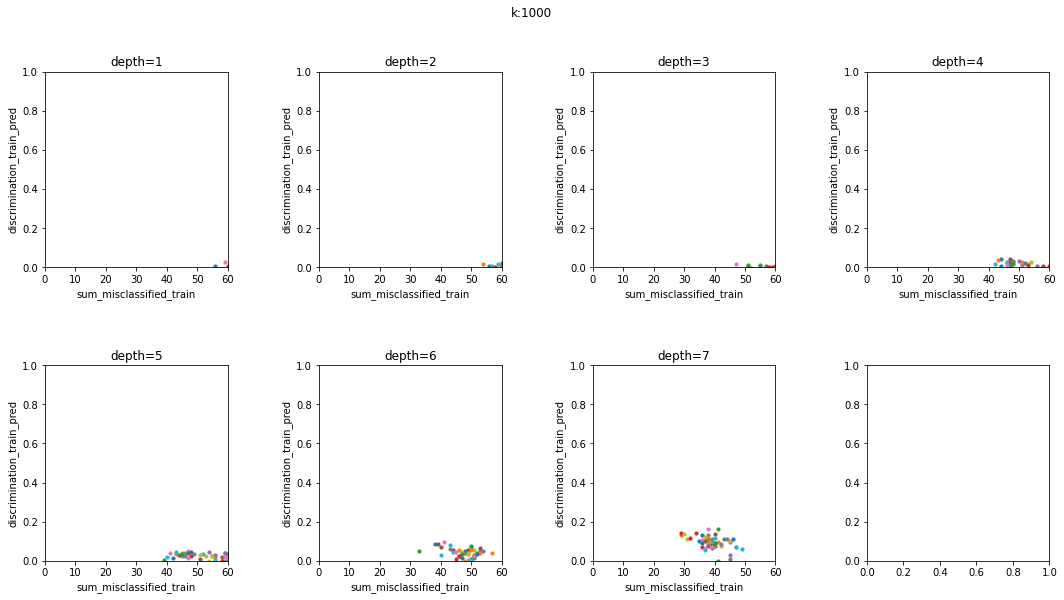

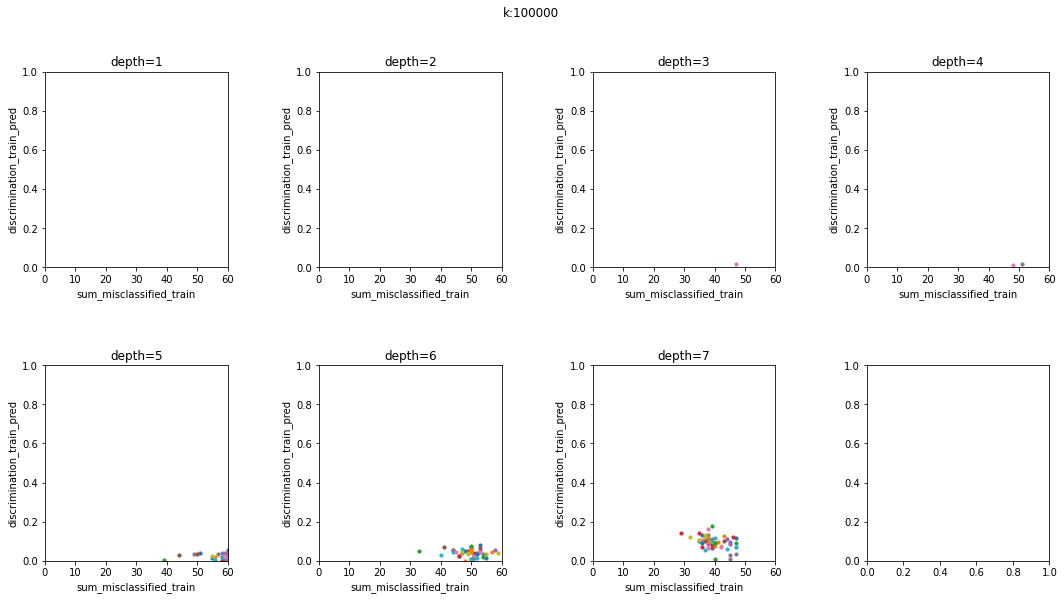

In [23]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

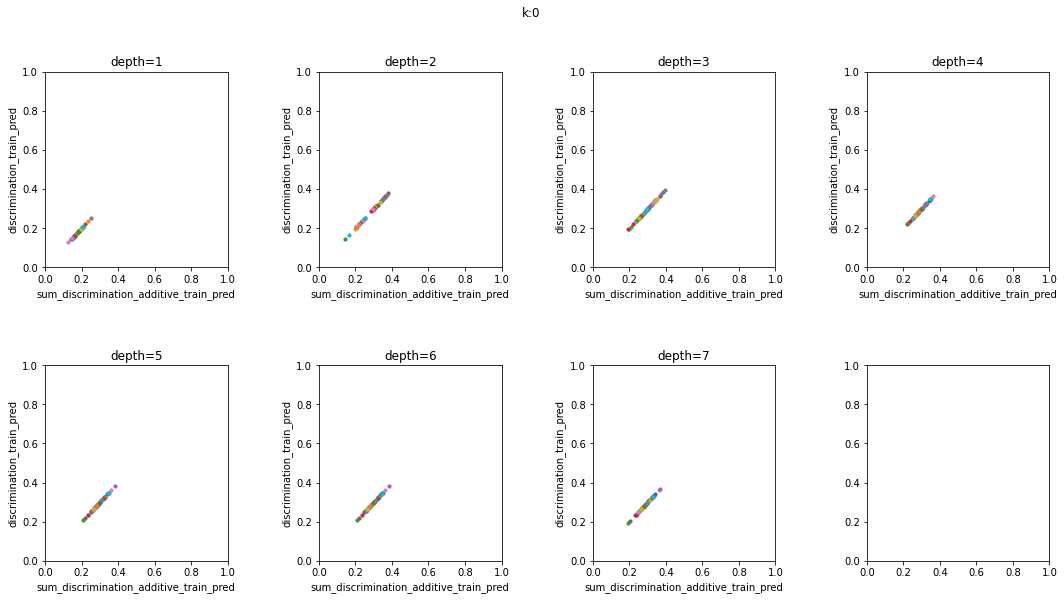

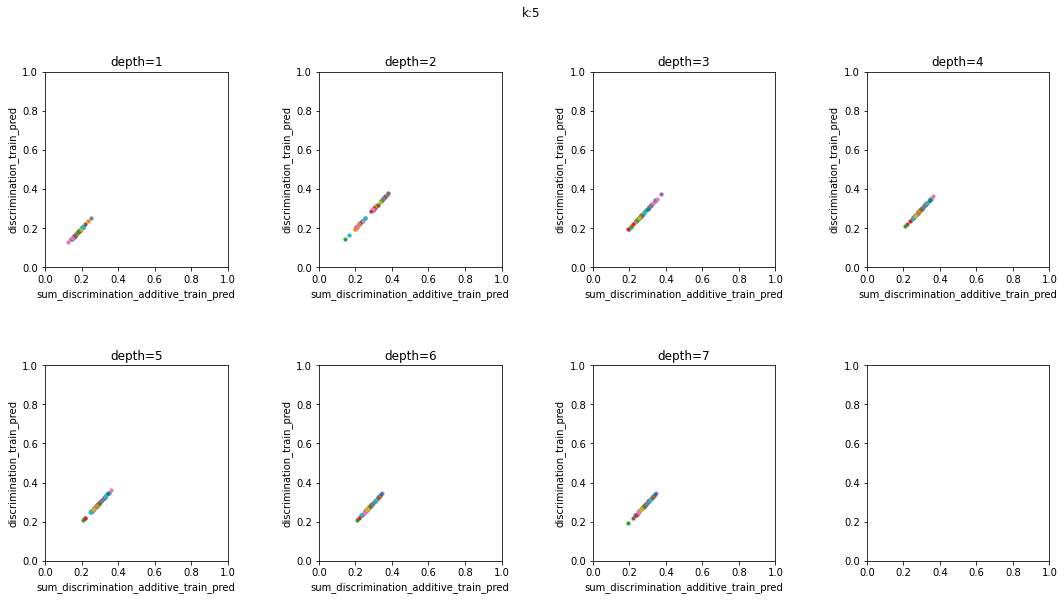

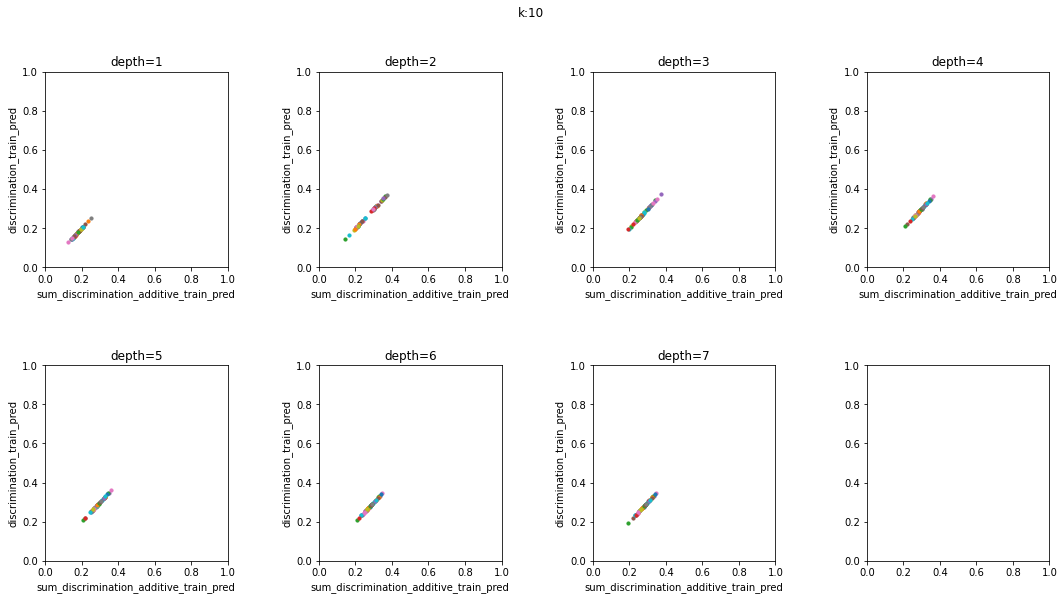

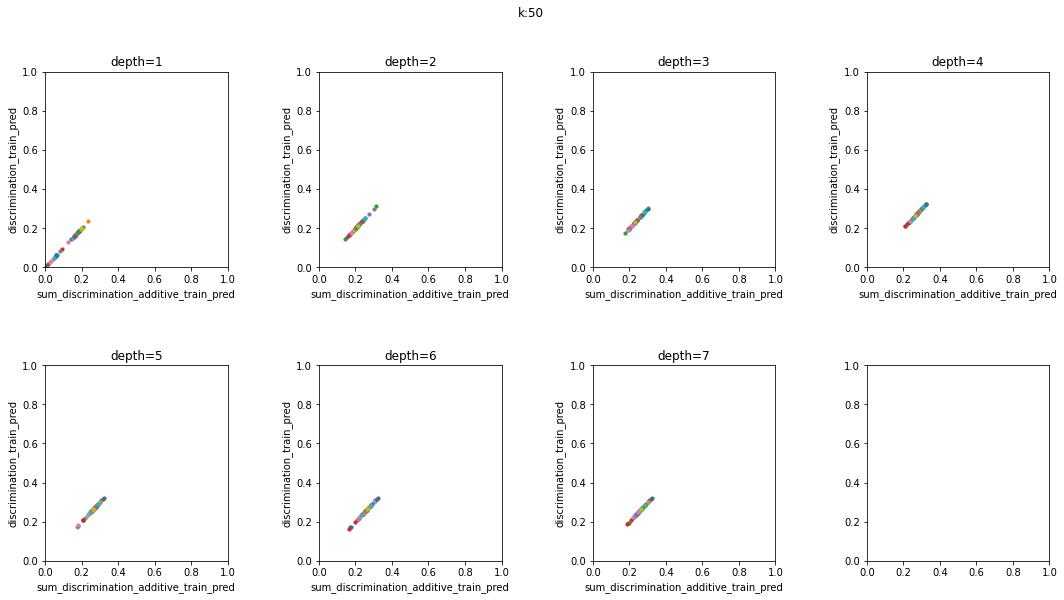

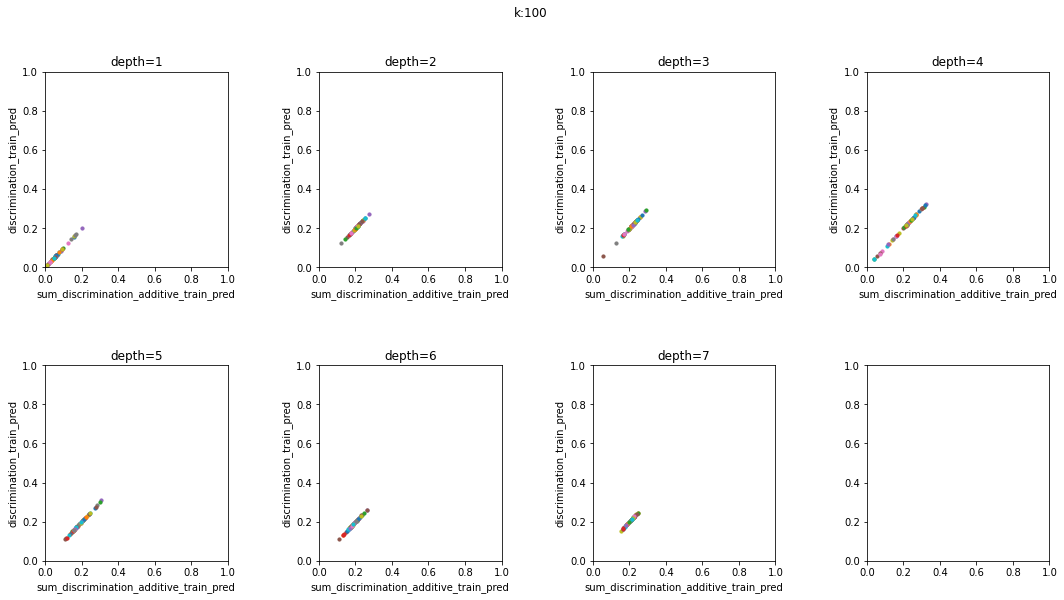

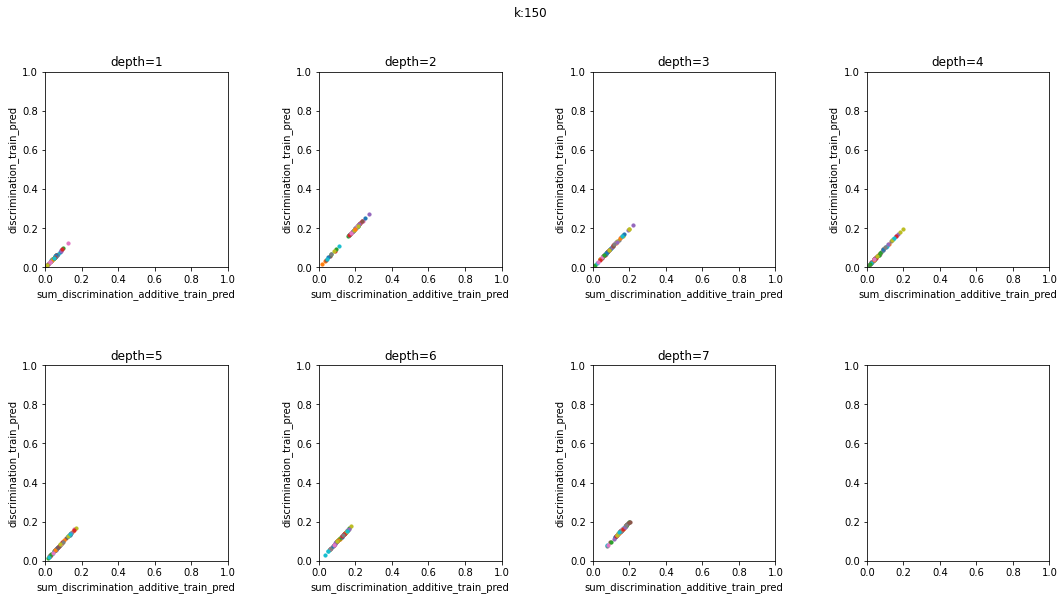

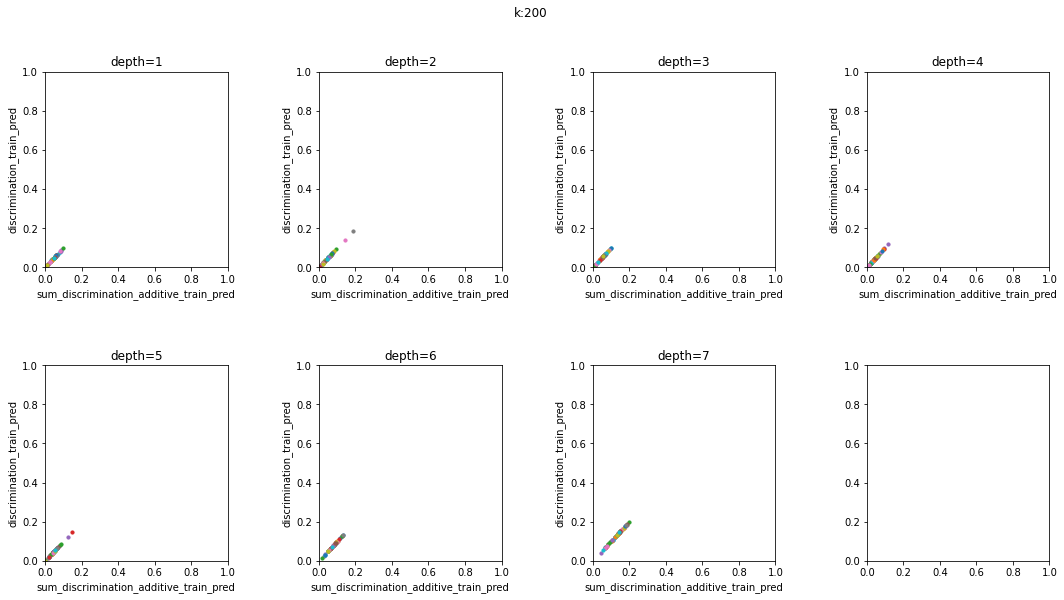

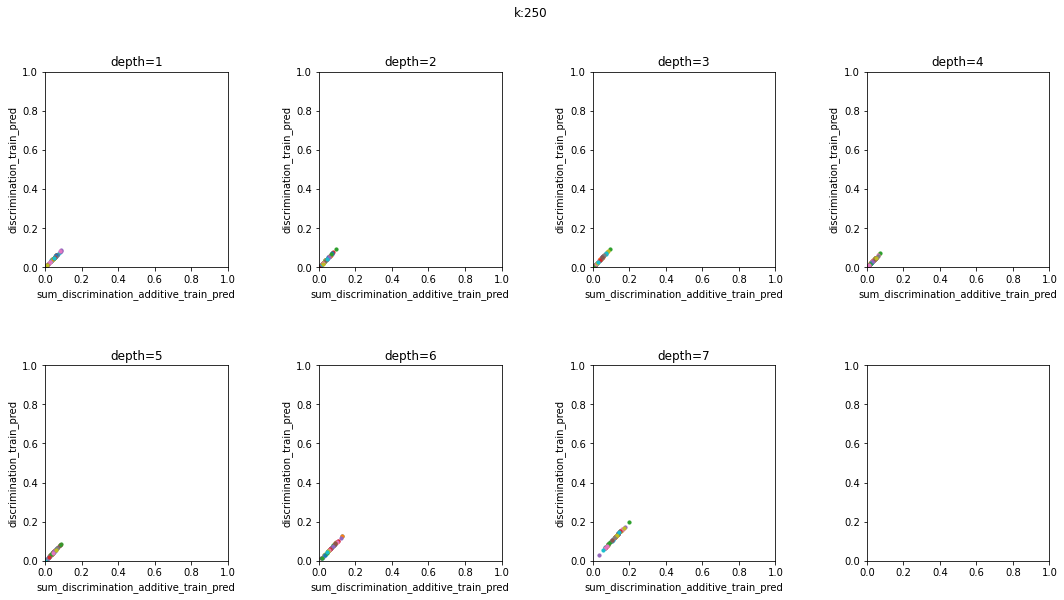

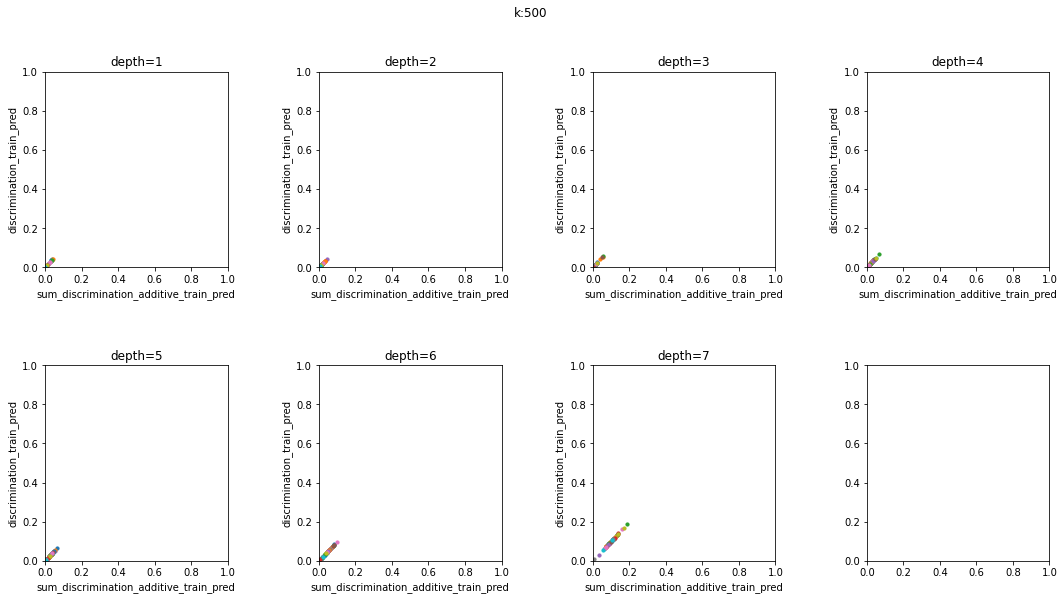

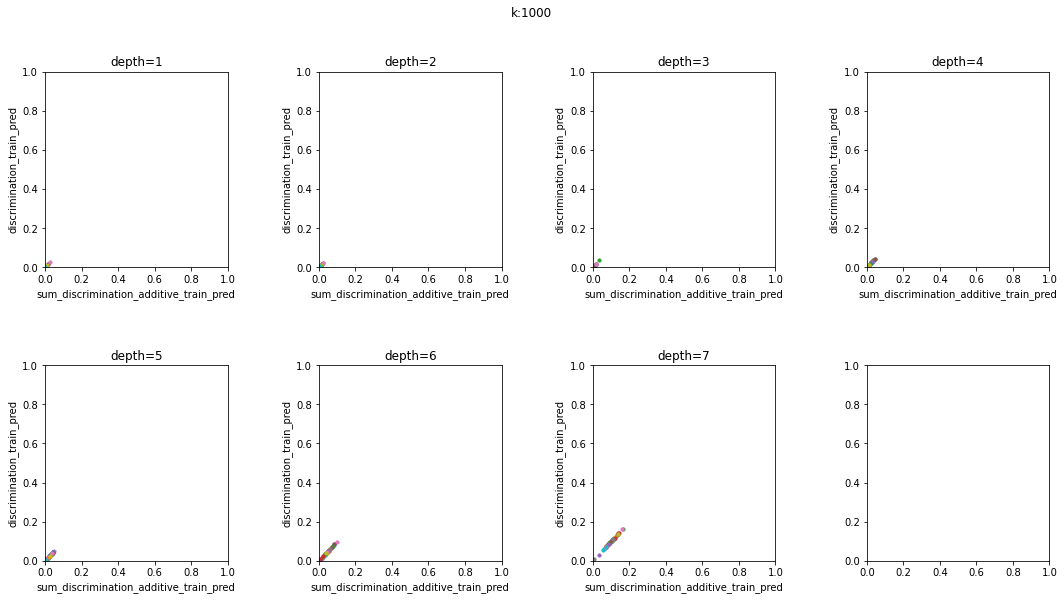

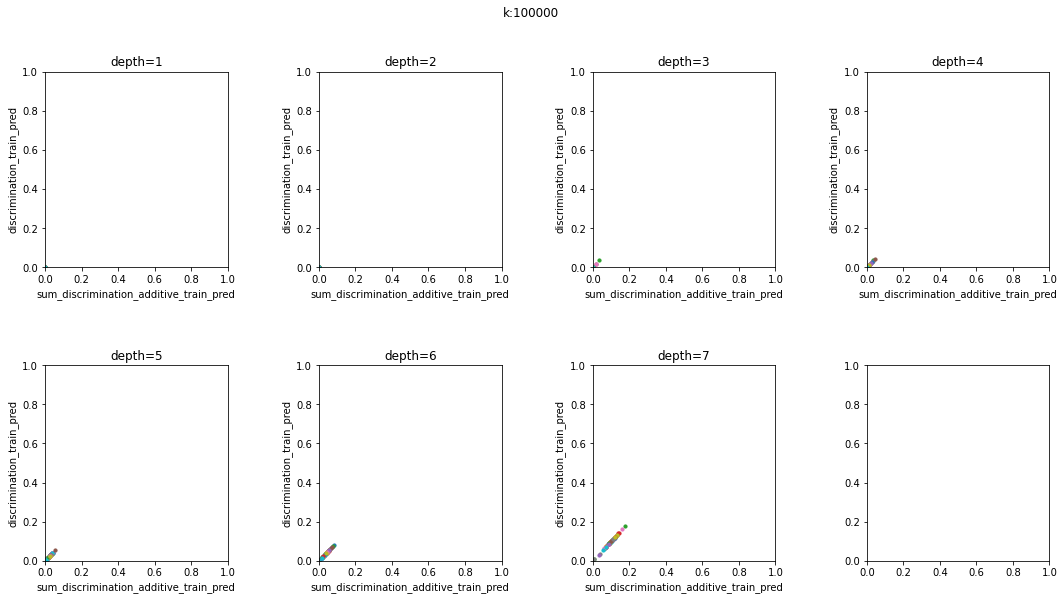

In [24]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

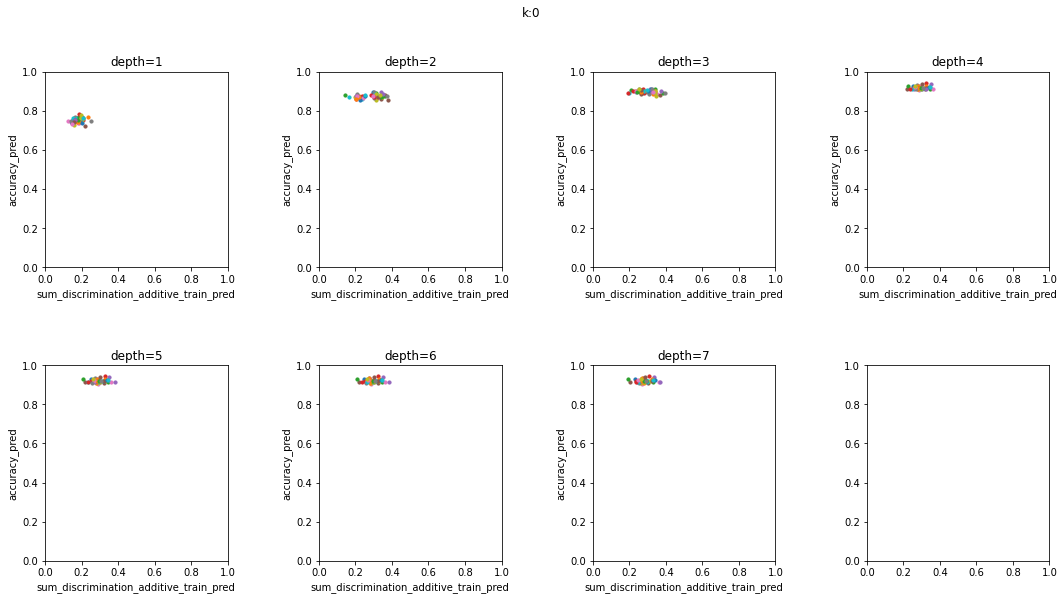

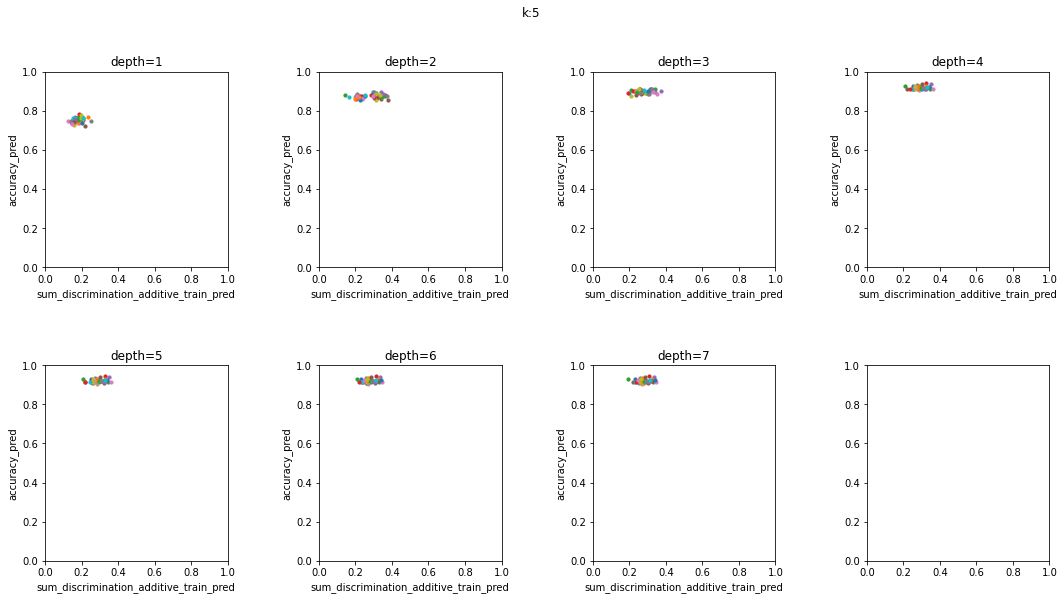

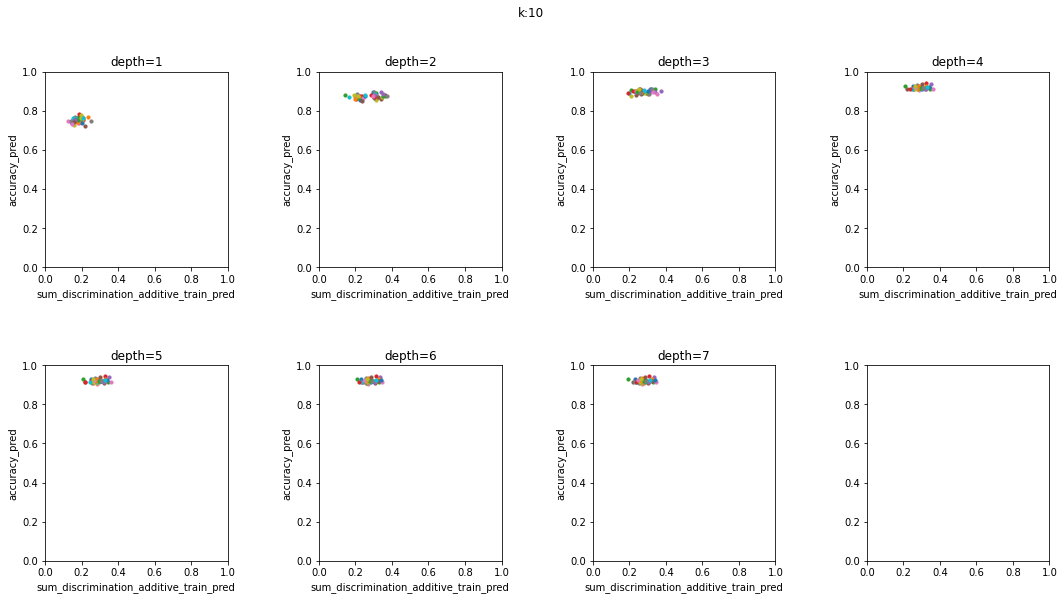

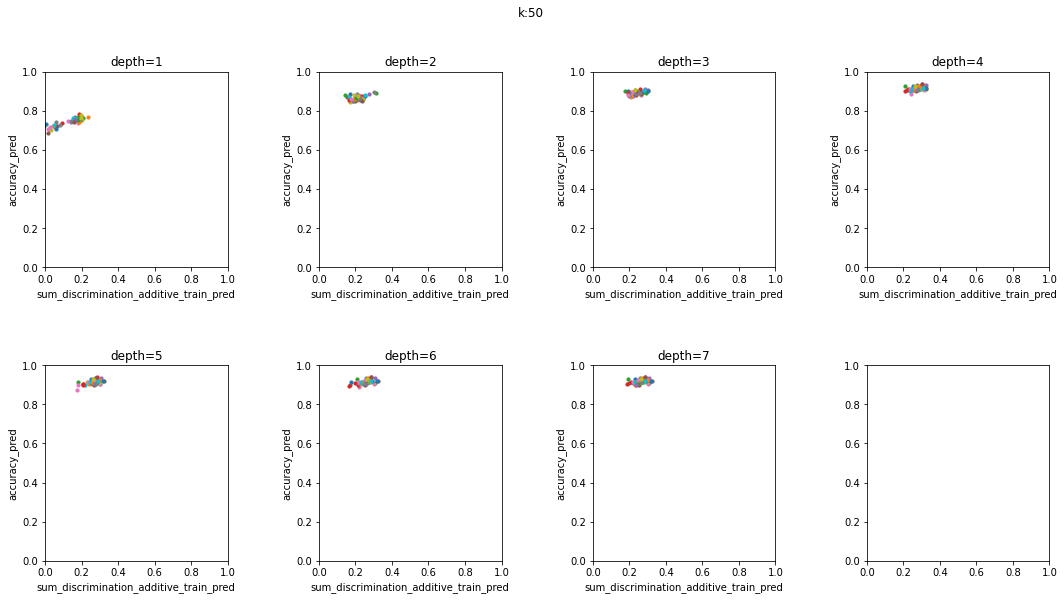

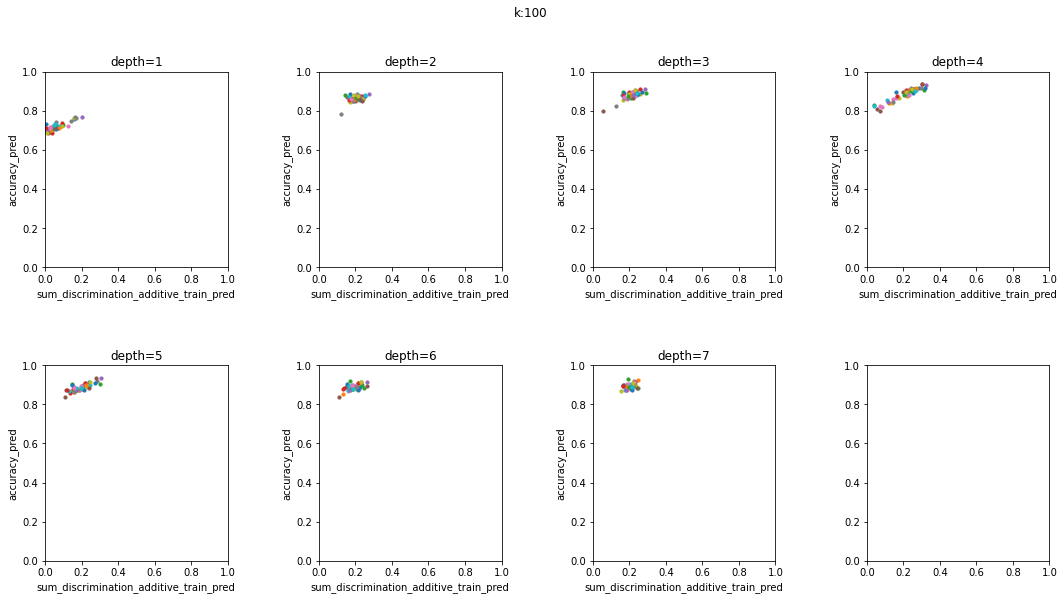

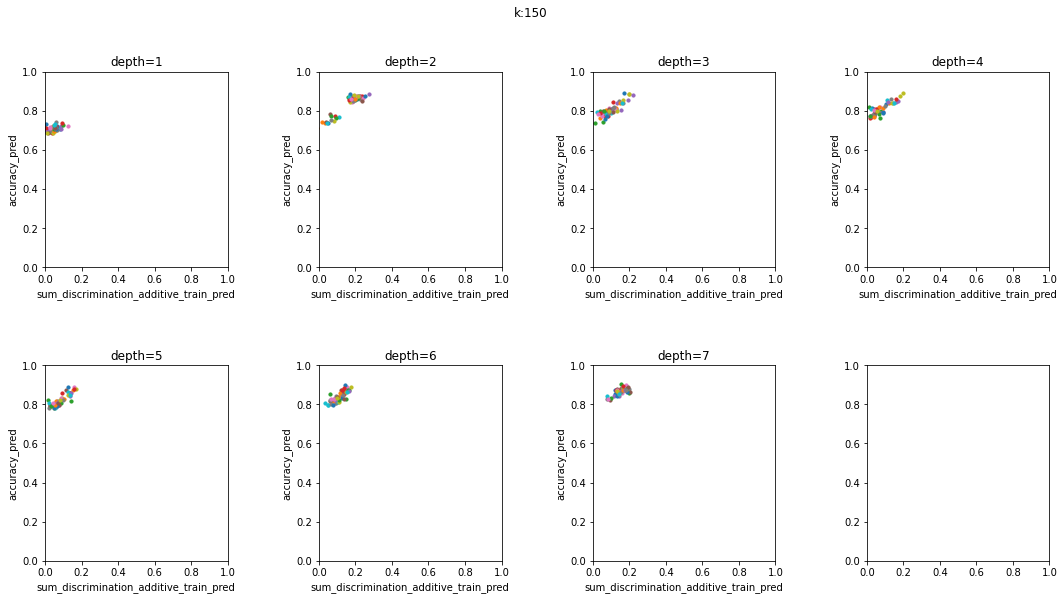

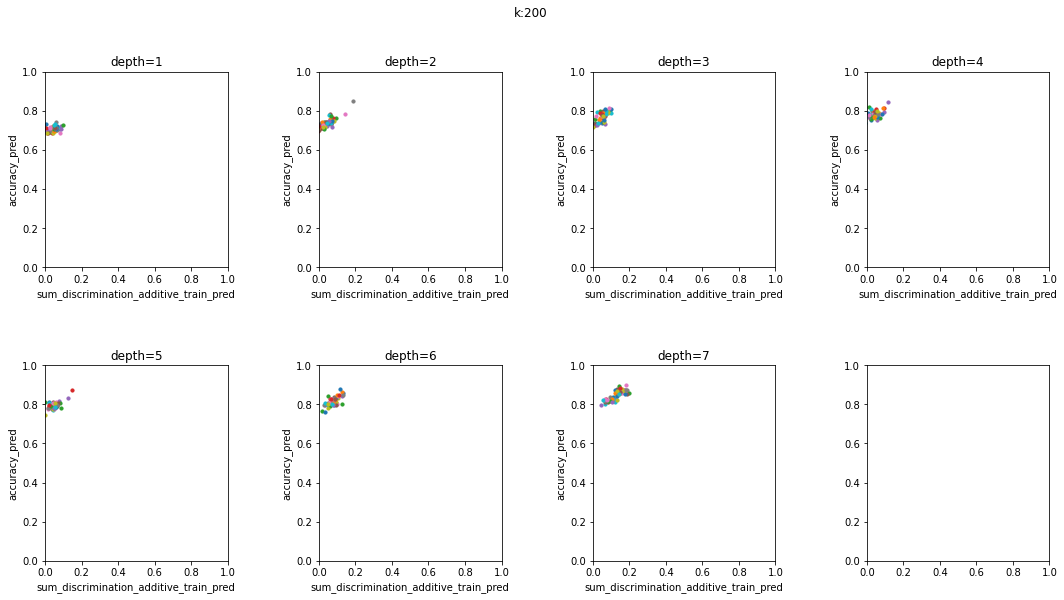

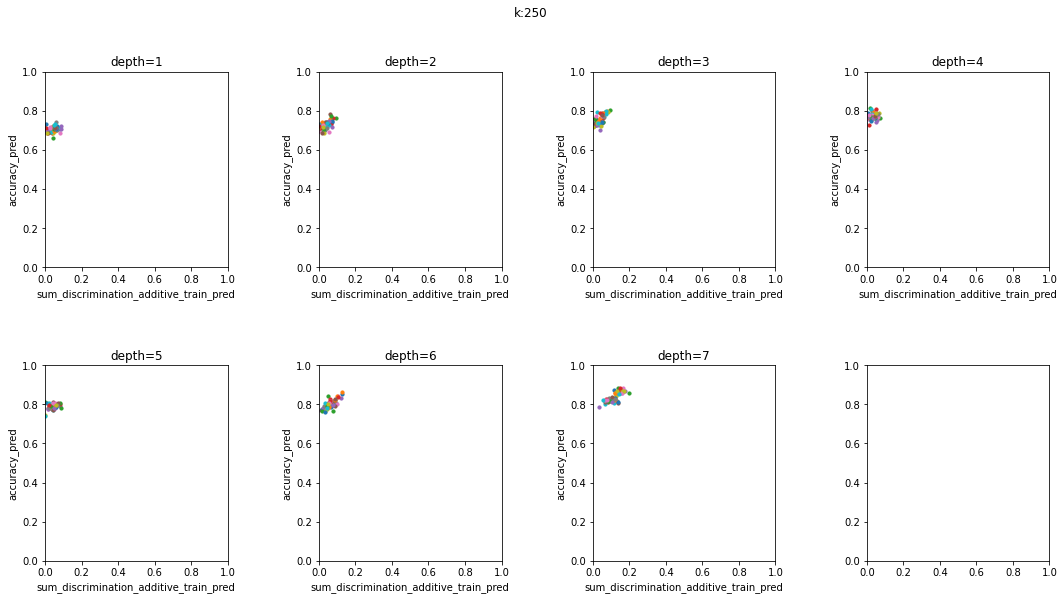

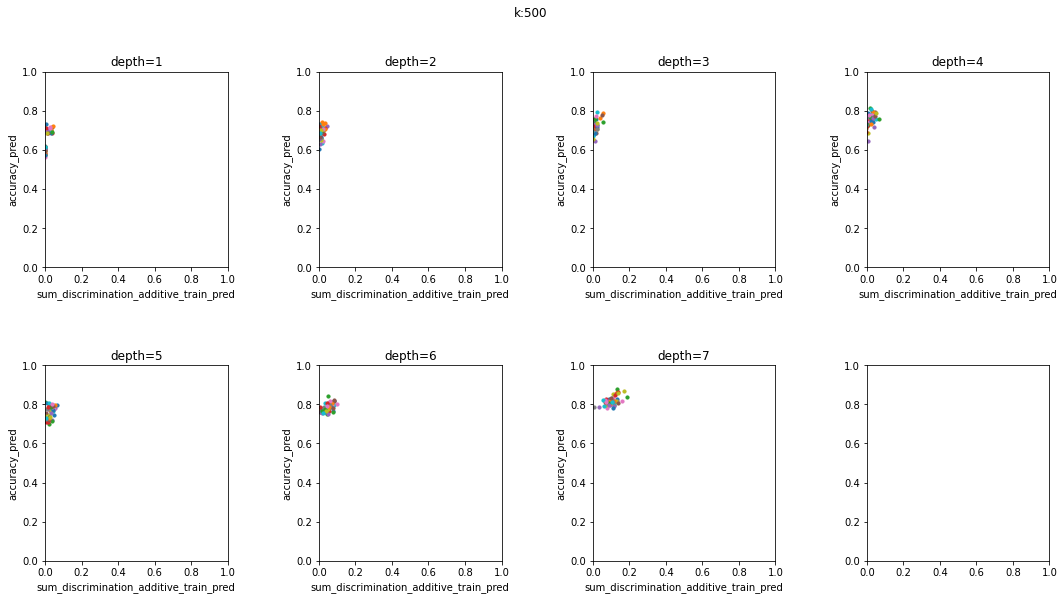

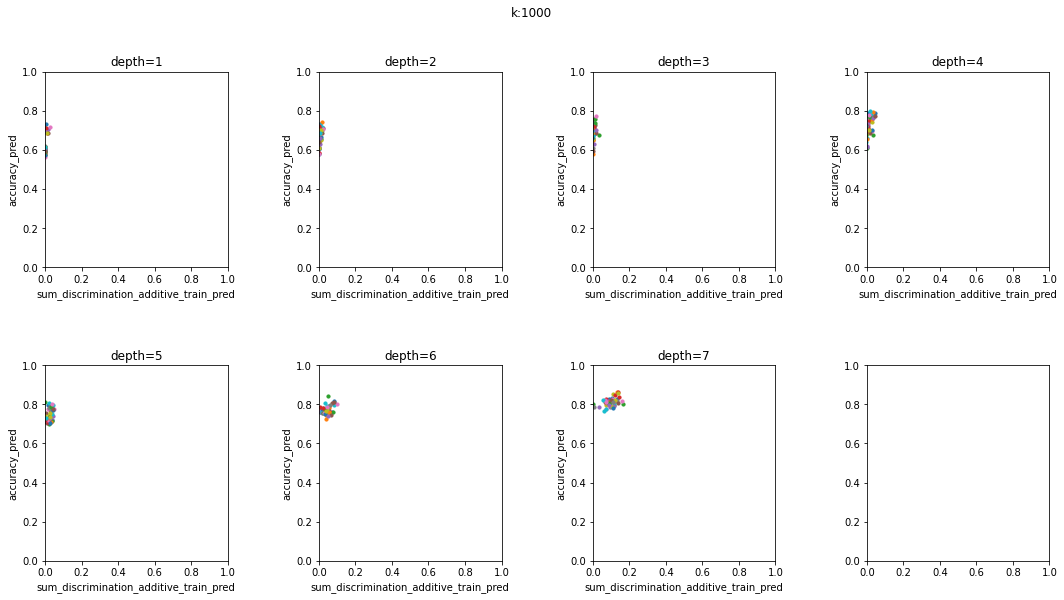

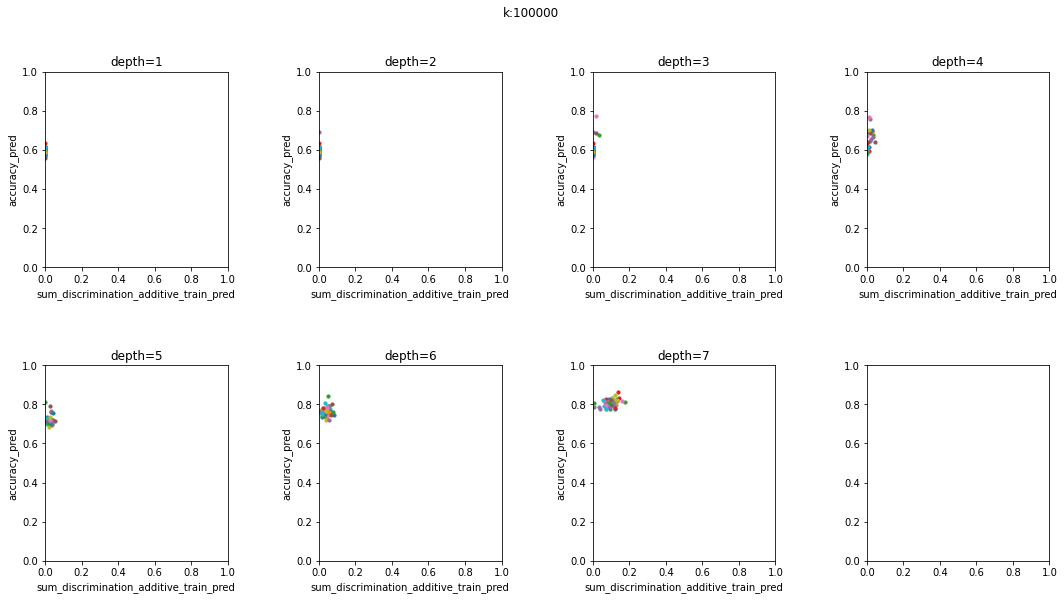

In [25]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

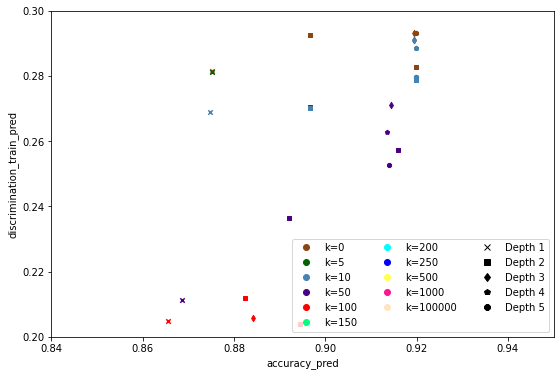

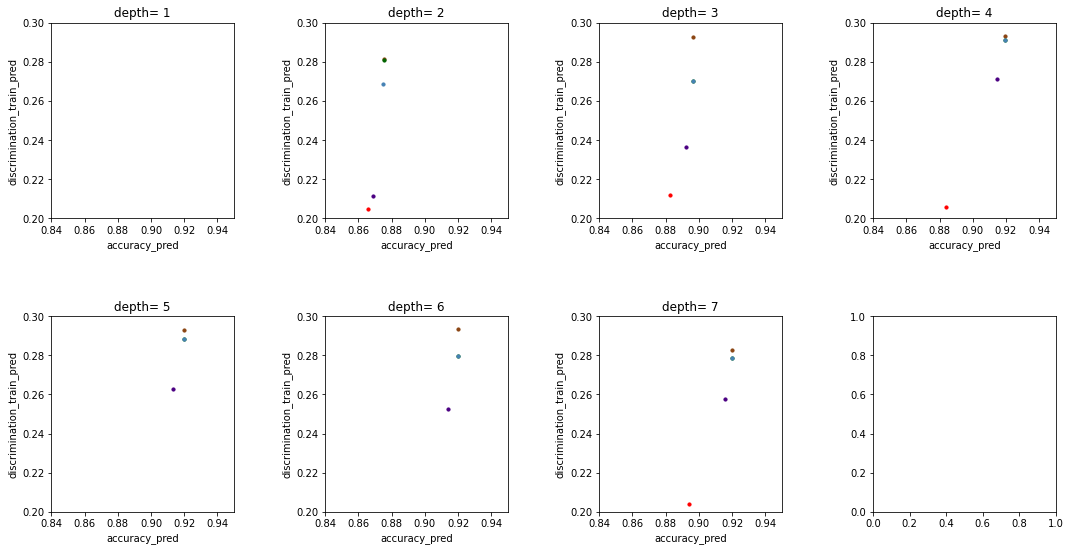

In [26]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

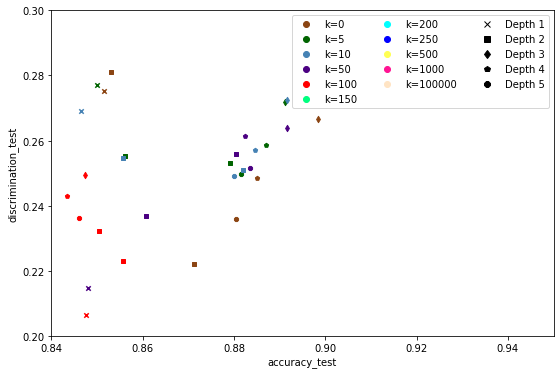

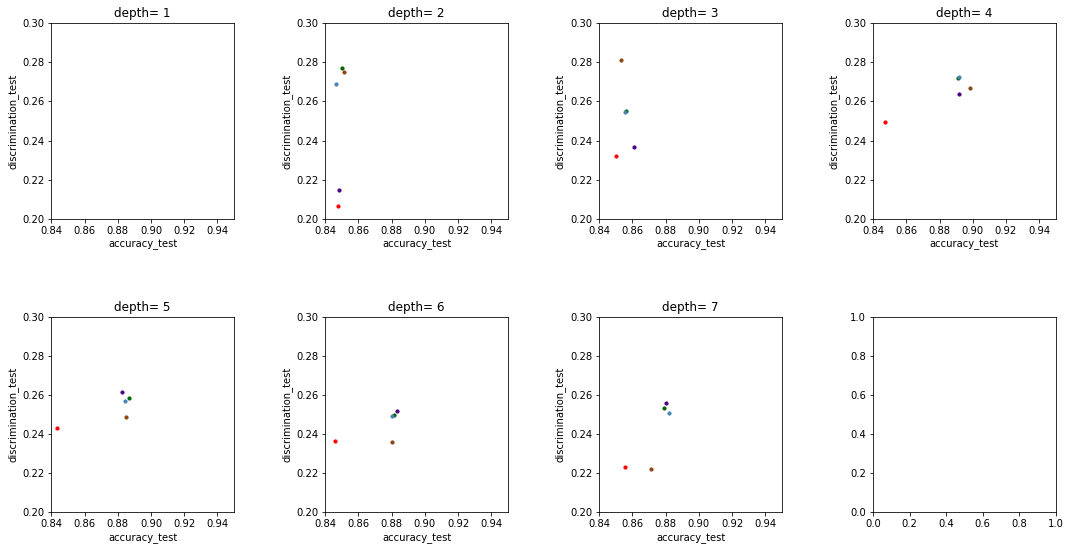

In [27]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

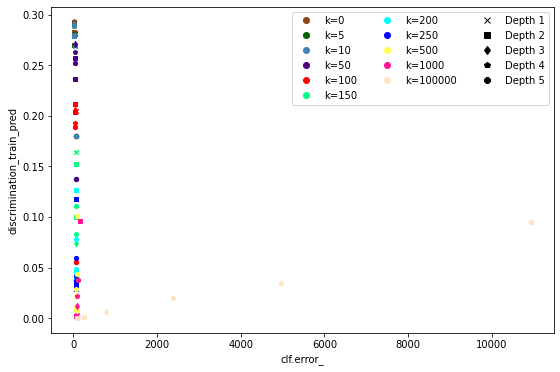

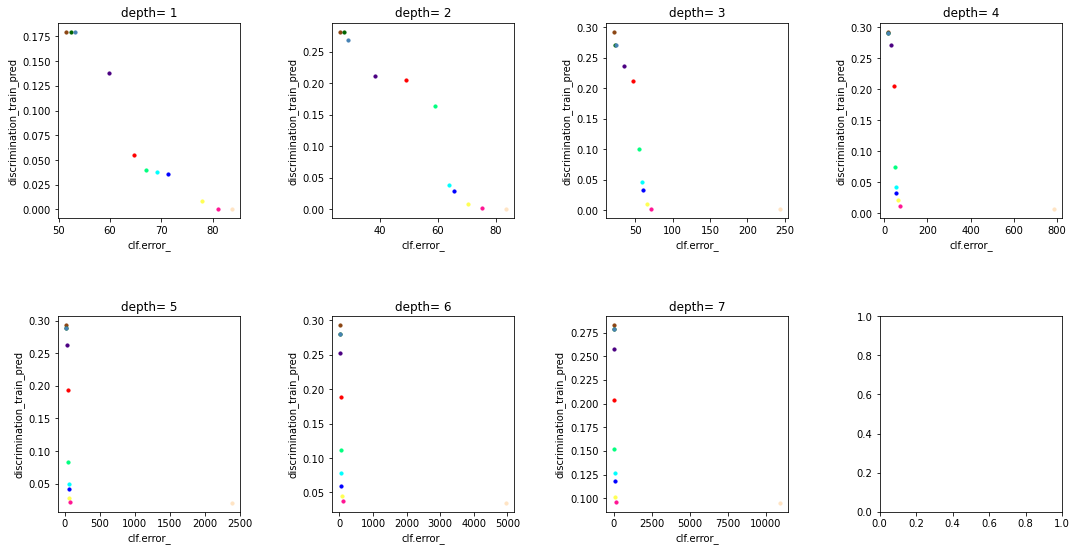

In [28]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

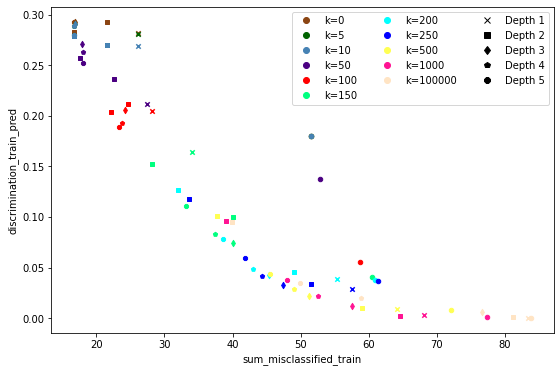

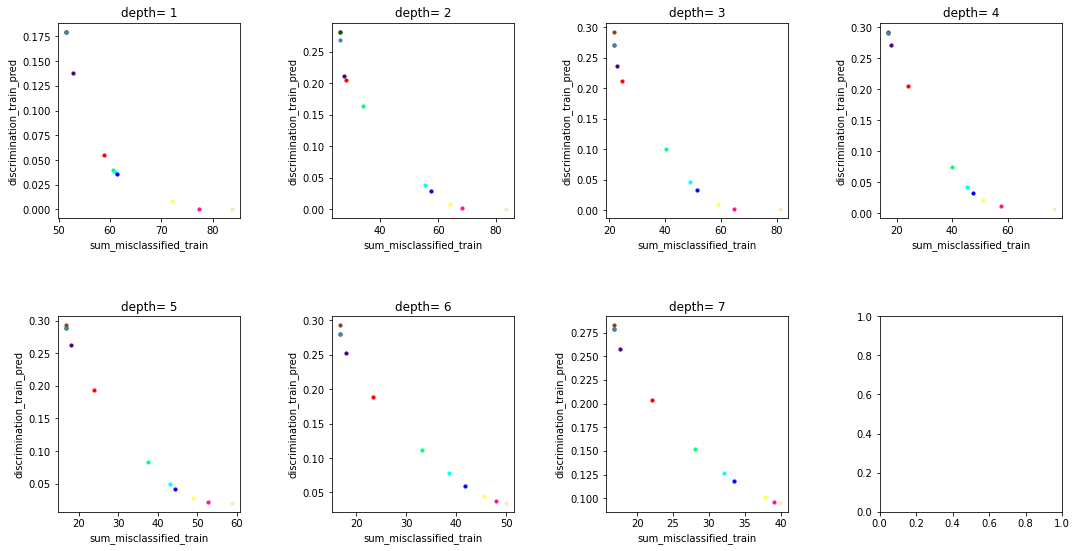

In [29]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

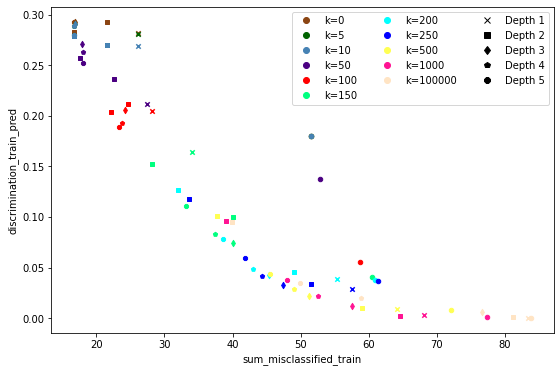

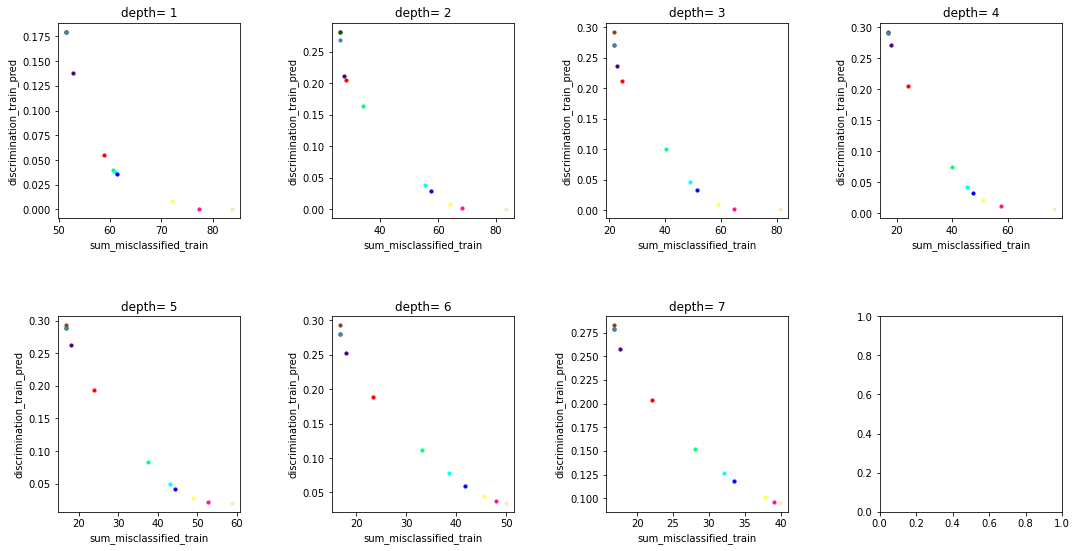

In [30]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

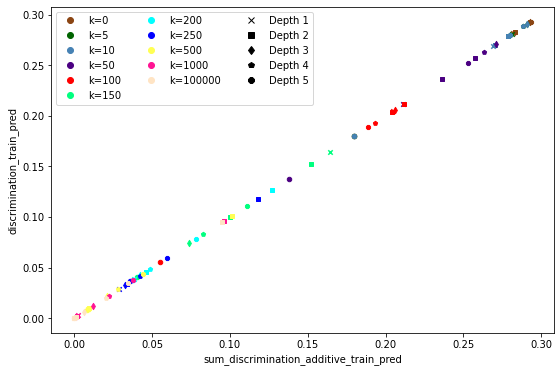

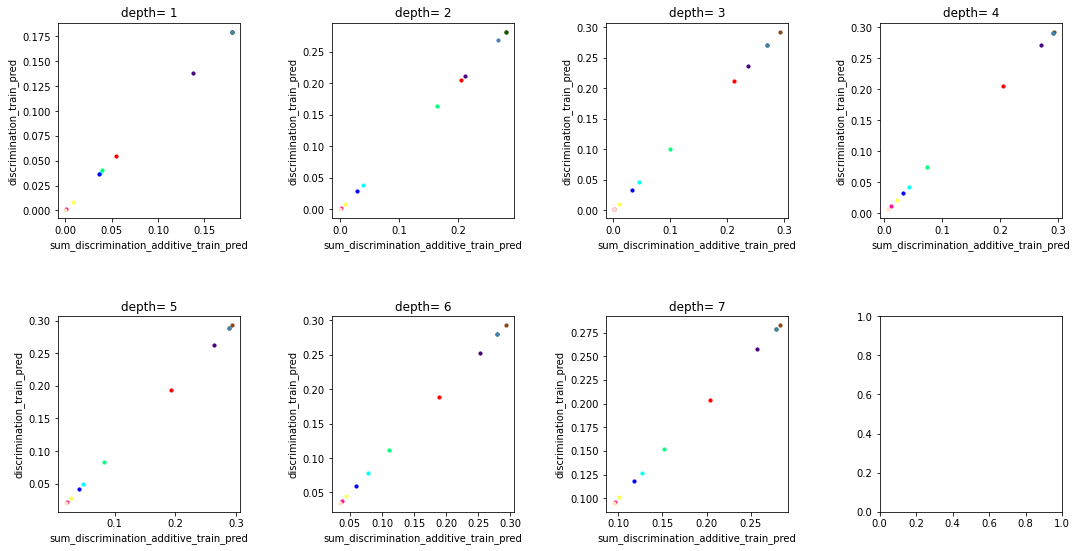

In [31]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

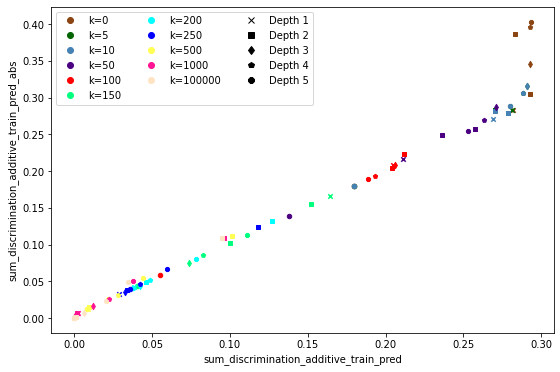

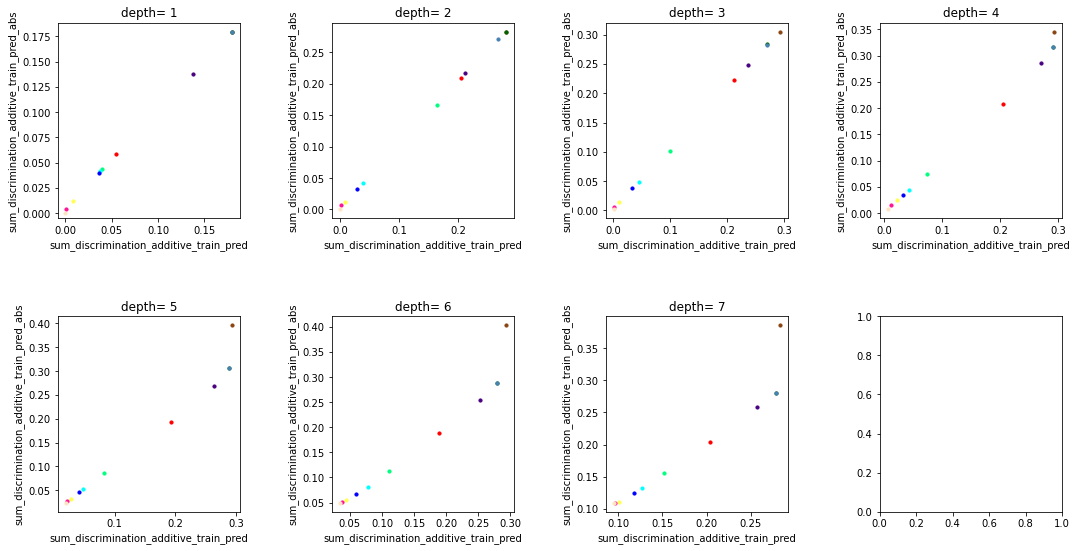

In [32]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)

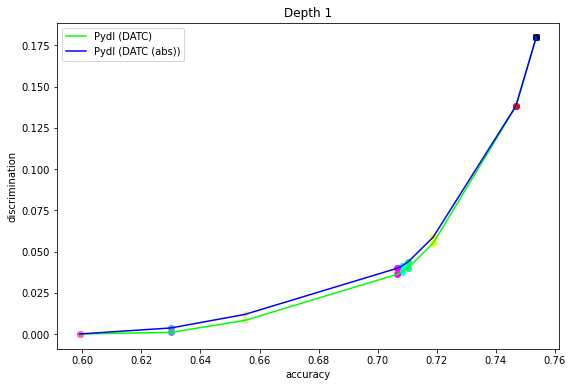

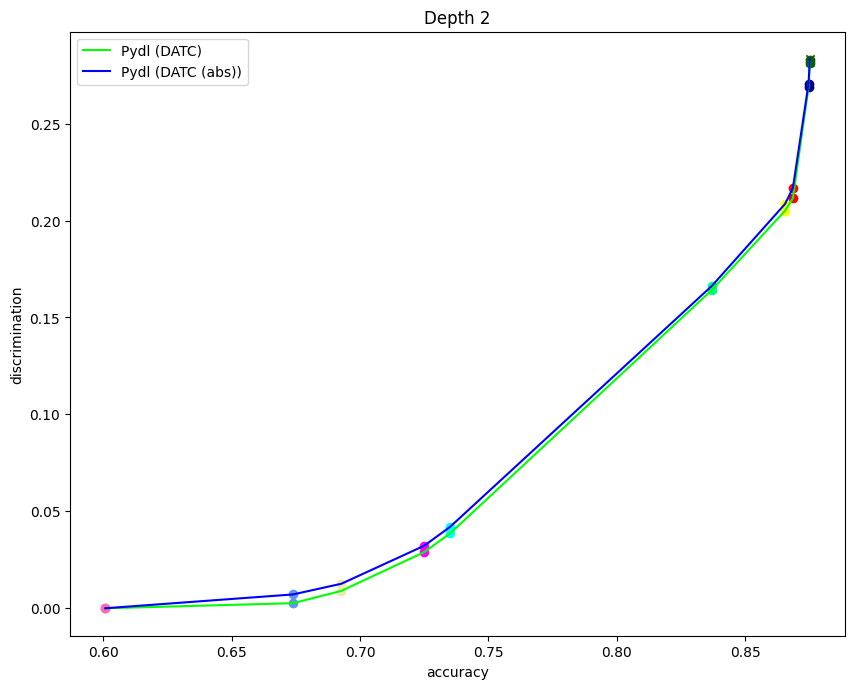

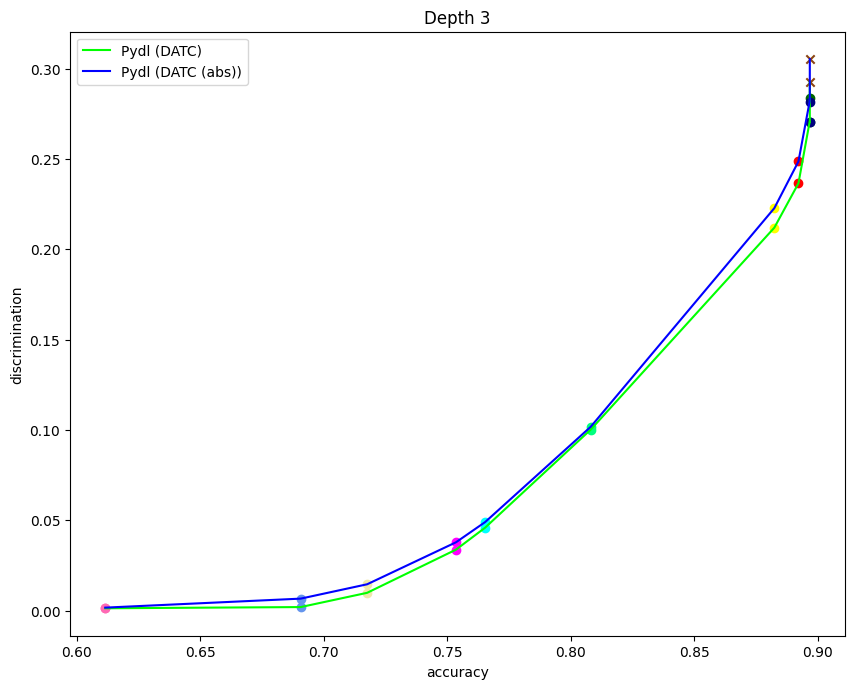

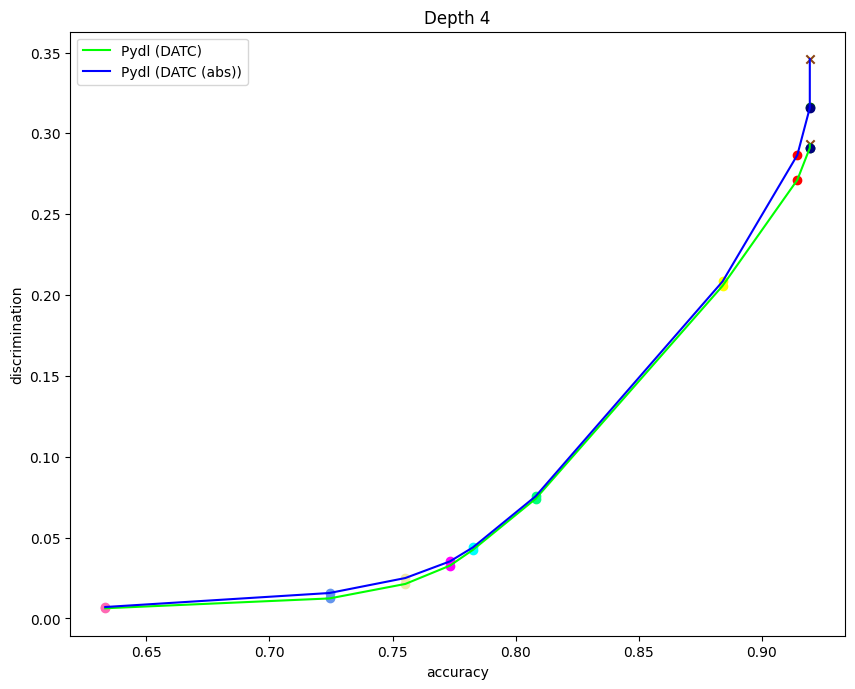

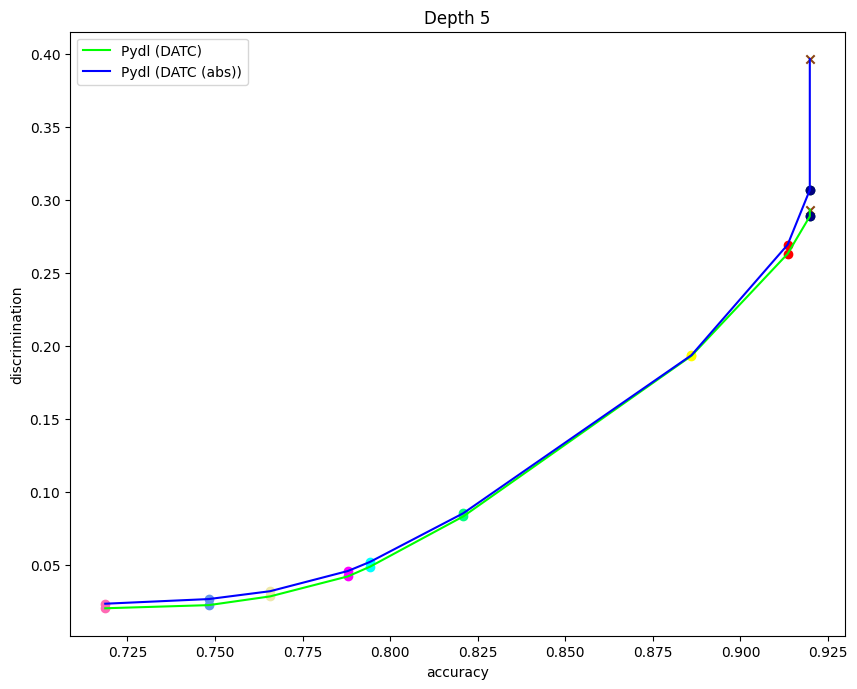

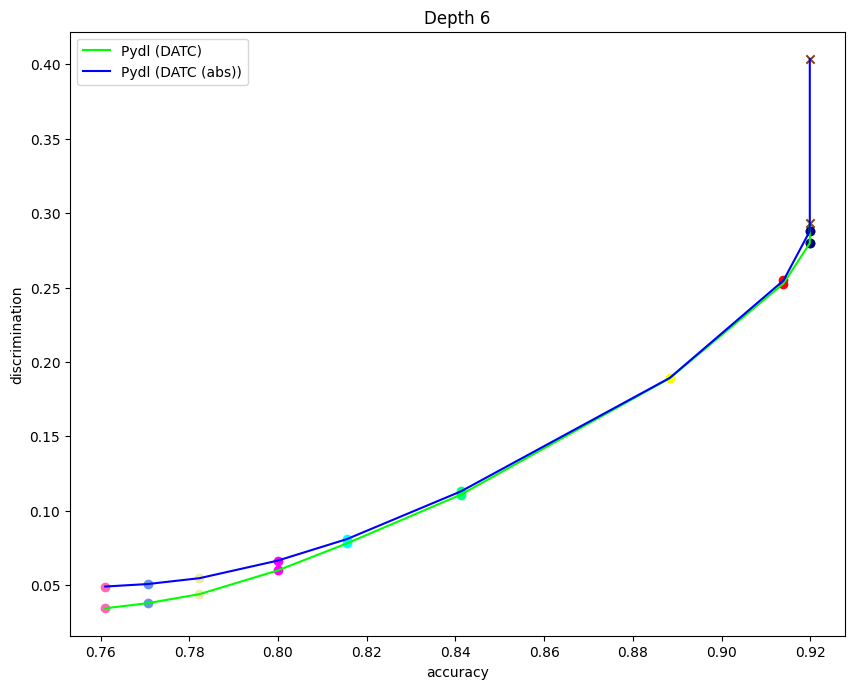

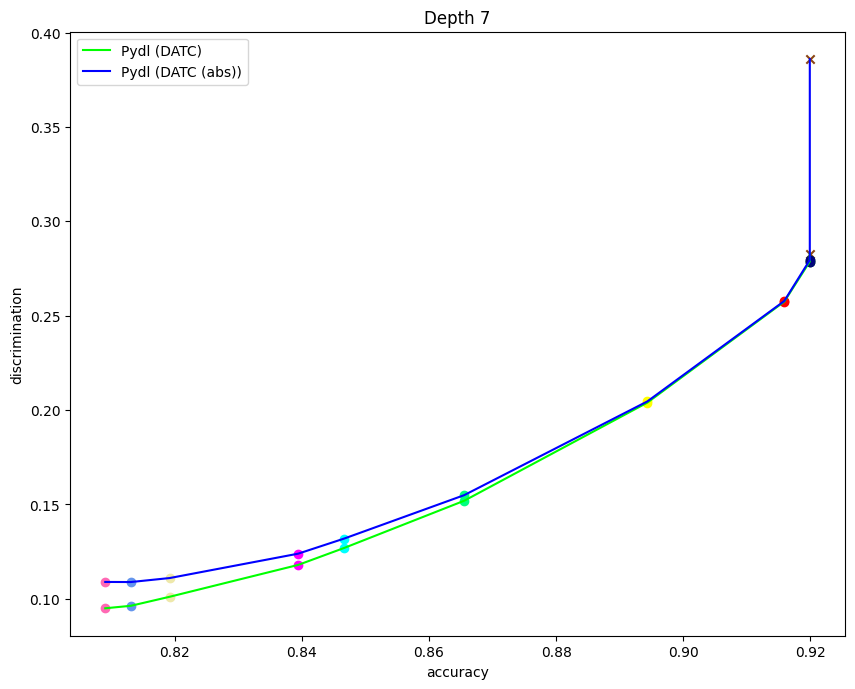

In [34]:
list_k = result["k"].unique()
list_k = [0, 5, 10, 50, 100, 150, 200, 250, 500, 1000, 100000]
_COLORS3 = ['#ff0000', '#00ff00', '#0000ff', '#008080']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS8 = ['#006400', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#00ffff', '#0000ff', '#1e90ff']
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#ffff00', '#00ff7f', '#00ffff', '#ff00ff', '#ffff54',
             '#ffe4c4']
_COLORS11 = ['#8b4513', '#006400', '#000080', '#ff0000', '#ffff00', '#00ff7f', '#00ffff', '#ff00ff', '#eee8aa', '#6495ed',
             '#ff69b4']

legends = ['< 0', '< 0.1', '< 0.2', '< 0.3', 'no relab']
fig, axes = plt.subplots()

for depth in result['depth'].unique():
    index_legends = 0
    y_values = list()
    x_values = list()
    y_values_pydl = list()
    x_values_pydl = list()
    axe2 = ("accuracy_pred", "sum_discrimination_additive_train_pred")
    x_axe = axe2[0]
    y_axe = axe2[1]
    index_legends = 0
    #for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
    for k in list_k:
        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        if index_legends == 0:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends], marker='x')
        else:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends])

        index_legends +=1

    plt.plot(x_values, y_values, label="Pydl (DATC)", c=_COLORS3[1])

    # PYDL 2
    y_values = list()
    x_values = list()

    axe2 = ("accuracy_pred", "sum_discrimination_additive_train_pred_abs")
    x_axe = axe2[0]
    y_axe = axe2[1]
    index_legends = 0
    #for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
    for k in list_k:
        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        if index_legends == 0:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends], marker='x')
        else:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends])

        index_legends +=1

    plt.plot(x_values, y_values, label="Pydl (DATC (abs))", c=_COLORS3[2])


    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.legend()

    plt.show()